<a href="https://colab.research.google.com/github/ATLAS097/Deep-Learning-CA-2/blob/Swam/GAN_Part_A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generative Adversarial Network - New Image Generation
### Group Member: Swam Htet Aung, Kaung Myat San
### Class: DAAA/FT/2B/22
---



### Setup
---

### Importing Modules

In [1]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle

# Deep learning libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms

# Utilities
import os
import warnings
from PIL import Image
from scipy import linalg
import random

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
torch.manual_seed(42)
random.seed(42)

# Suppress warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")
print(f"PyTorch version: {torch.__version__}")
print(f"GPU available (TensorFlow): {tf.config.list_physical_devices('GPU')}")
print(f"GPU available (PyTorch): {torch.cuda.is_available()}")

gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)
  tf.config.set_logical_device_configuration(gpu, [tf.config.LogicalDeviceConfiguration(memory_limit=6144)]) # 6GB limit per GPU

print(tf.config.list_physical_devices())


Libraries imported successfully!
TensorFlow version: 2.18.0
PyTorch version: 2.6.0+cu124
GPU available (TensorFlow): [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU available (PyTorch): True
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Background Research & Data Analysis
---
### Data Loading and Exploration
---
Let's load the EMNIST letters dataset and analyze its structure.

In [2]:
# Load the EMNIST letters dataset
data = pd.read_csv('https://media.githubusercontent.com/media/ATLAS097/assets/refs/heads/main/SP_DELE_CA2_YEAR_2/emnist-letters-train.csv', header=None)

# Rename columns for clarity (first column is label, rest are pixel values)
column_names = ['label'] + [f'pixel_{i}' for i in range(784)]
data.columns = column_names

print(f"Dataset shape: {data.shape}")
print(f"Dataset columns: {data.columns.tolist()}")
print(f"First few column names: {data.columns[:10].tolist()}")

# Check for missing values
print(f"\nMissing values: {data.isnull().sum().sum()}")

# Display first few rows
print("\nFirst 5 rows:")
print(data.head())

# Check unique labels
if '0' in data.columns:
    unique_labels = sorted(data['0'].unique())
    print(f"\nUnique labels: {unique_labels}")
    print(f"Number of classes: {len(unique_labels)}")

    # Label distribution
    label_counts = data['0'].value_counts().sort_index()
    print(f"\nLabel distribution:")
    for label, count in label_counts.items():
        print(f"Class {label}: {count} samples")

    # Plot label distribution
    plt.figure(figsize=(12, 6))
    plt.bar(label_counts.index, label_counts.values)
    plt.title('Distribution of Letter Classes in EMNIST Dataset')
    plt.xlabel('Letter Class')
    plt.ylabel('Number of Samples')
    plt.xticks(label_counts.index)
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    print("Label column not found. Checking dataset structure...")
    print(data.describe())

Dataset shape: (64829, 785)
Dataset columns: ['label', 'pixel_0', 'pixel_1', 'pixel_2', 'pixel_3', 'pixel_4', 'pixel_5', 'pixel_6', 'pixel_7', 'pixel_8', 'pixel_9', 'pixel_10', 'pixel_11', 'pixel_12', 'pixel_13', 'pixel_14', 'pixel_15', 'pixel_16', 'pixel_17', 'pixel_18', 'pixel_19', 'pixel_20', 'pixel_21', 'pixel_22', 'pixel_23', 'pixel_24', 'pixel_25', 'pixel_26', 'pixel_27', 'pixel_28', 'pixel_29', 'pixel_30', 'pixel_31', 'pixel_32', 'pixel_33', 'pixel_34', 'pixel_35', 'pixel_36', 'pixel_37', 'pixel_38', 'pixel_39', 'pixel_40', 'pixel_41', 'pixel_42', 'pixel_43', 'pixel_44', 'pixel_45', 'pixel_46', 'pixel_47', 'pixel_48', 'pixel_49', 'pixel_50', 'pixel_51', 'pixel_52', 'pixel_53', 'pixel_54', 'pixel_55', 'pixel_56', 'pixel_57', 'pixel_58', 'pixel_59', 'pixel_60', 'pixel_61', 'pixel_62', 'pixel_63', 'pixel_64', 'pixel_65', 'pixel_66', 'pixel_67', 'pixel_68', 'pixel_69', 'pixel_70', 'pixel_71', 'pixel_72', 'pixel_73', 'pixel_74', 'pixel_75', 'pixel_76', 'pixel_77', 'pixel_78', 'pixel_

Dataset Summary & Key Observations

- **Total Samples**:  
  The dataset contains a total of **64,829** samples.

- **Image Properties**:  
  - Each sample is a flattened array of **784 pixels**, which can be reshaped into a $28 \times 28$ grayscale image.  
  - The data is highly **sparse**: the 75th percentile for most pixel columns is 0, indicating that the majority of the image area is background.

- **Label Properties**:  
  - Labels are integers ranging from **-2 to 26**.  
  - These labels are not sequential and must be mapped correctly to the **16 target classes** for model training.

- **Required Preprocessing**:  
  - Pixel intensity values currently range from **0 to 255**.  
  - These should be **normalized** (e.g., scaled to a `[-1, 1]` range) to ensure stable and effective model training.




### Visualizing the Images by Class
---

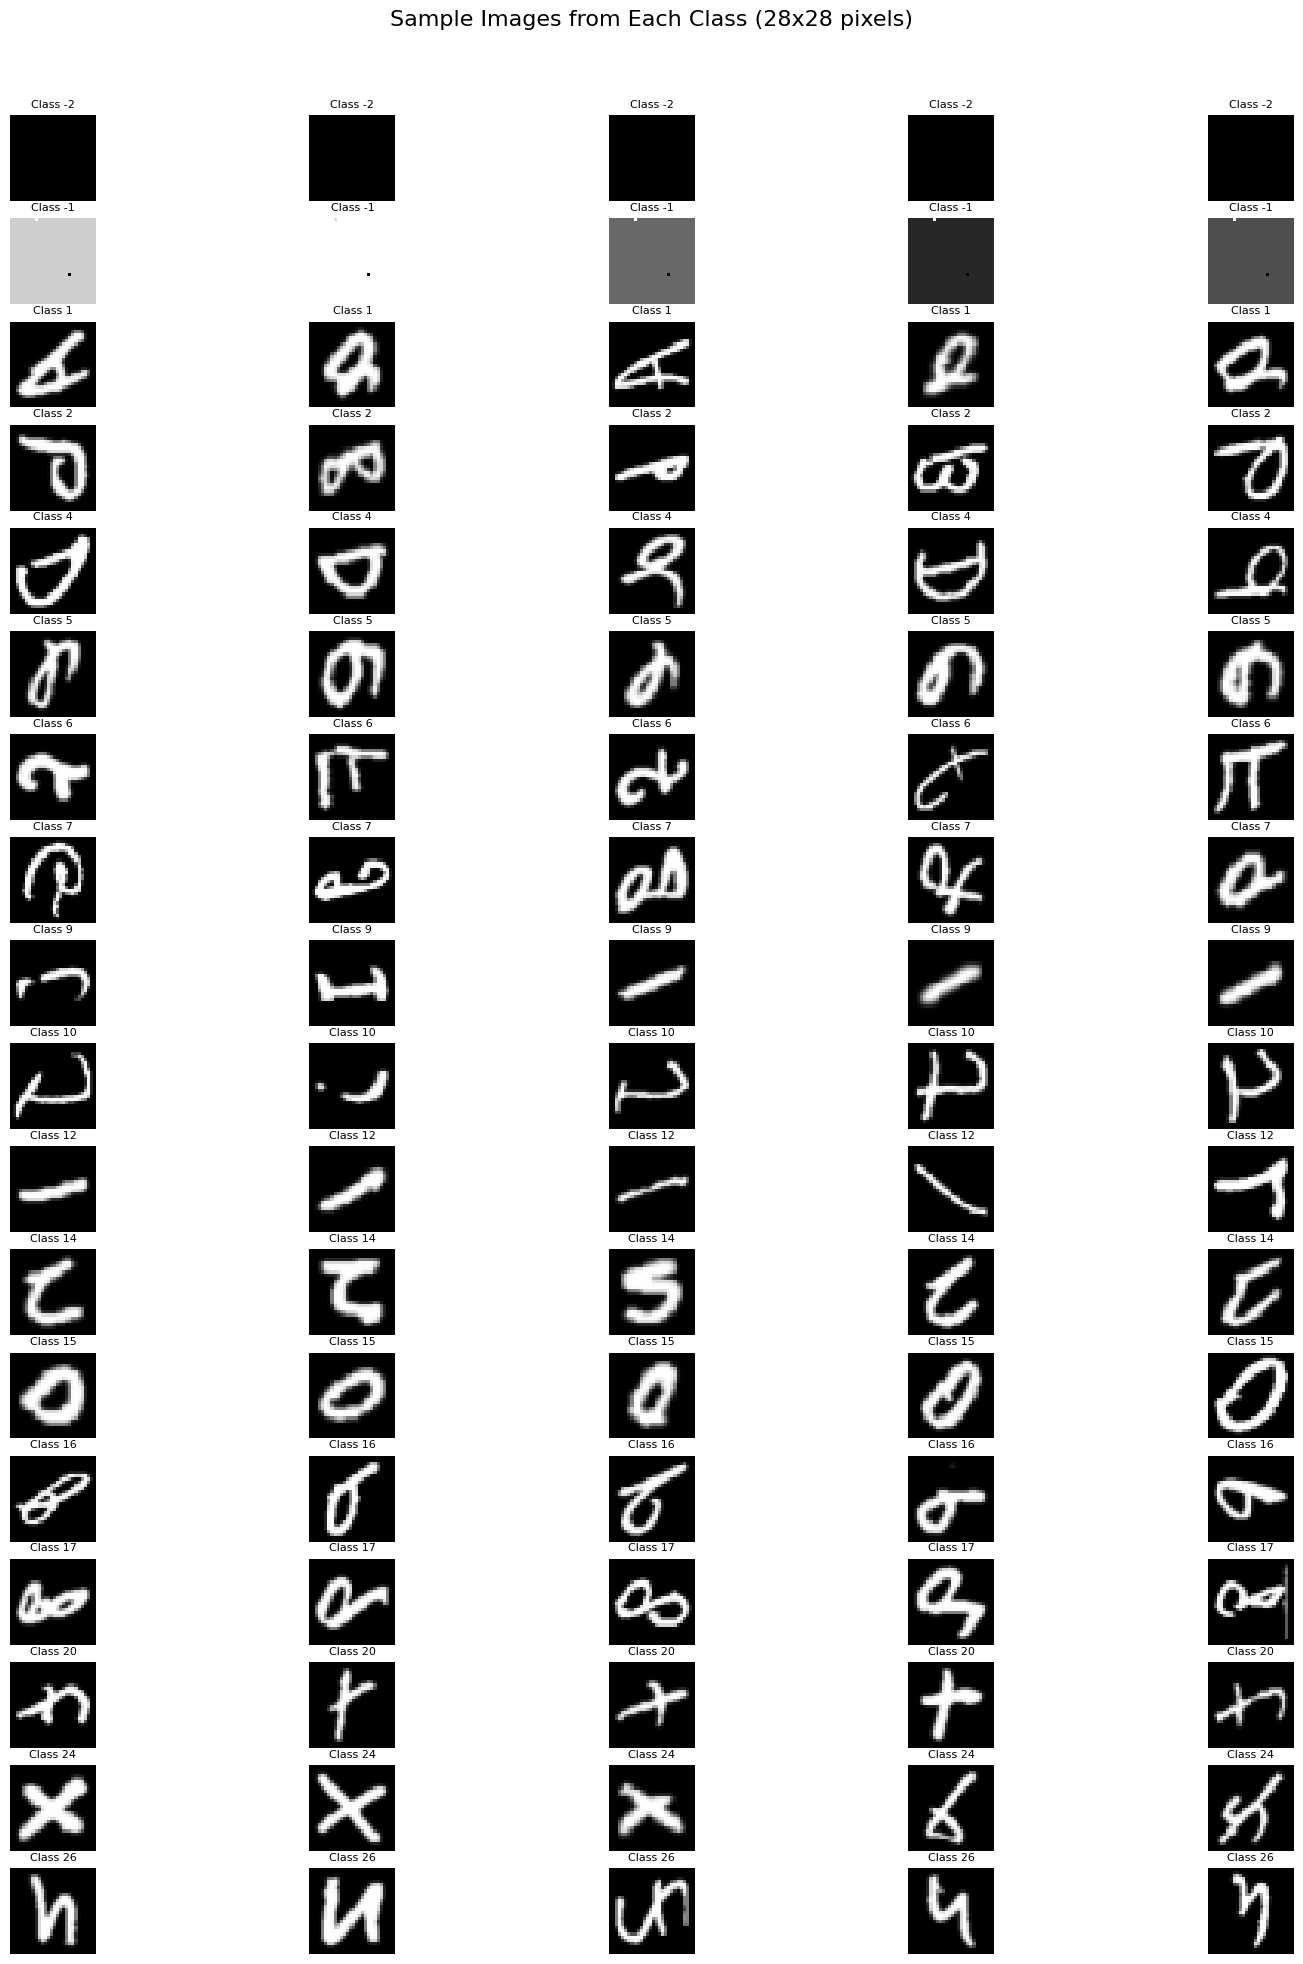

In [3]:
# Visualize sample images from different classes
def visualize_samples(data, n_samples=5, figsize=(15, 20)):
    """Visualize random samples from each class"""
    if 'label' not in data.columns:
        print("Label column not found")
        return

    unique_labels = sorted(data['label'].unique())
    n_classes = len(unique_labels)

    fig, axes = plt.subplots(n_classes, n_samples, figsize=figsize)
    fig.suptitle(f'Sample Images from Each Class (28x28 pixels)', fontsize=16)

    for i, label in enumerate(unique_labels):
        class_data = data[data['label'] == label]
        samples = class_data.sample(n=min(n_samples, len(class_data)))

        for j in range(n_samples):
            if j < len(samples):
                # Get pixel values (excluding the label column)
                pixel_values = samples.iloc[j, 1:].values
                # Reshape to 28x28 image
                image = pixel_values.reshape(28, 28)

                if n_classes == 1:
                    axes[j].imshow(image, cmap='gray')
                    axes[j].set_title(f'Class {label}', fontsize=8)
                    axes[j].axis('off')
                else:
                    axes[i, j].imshow(image, cmap='gray')
                    if j == 0:
                        axes[i, j].set_ylabel(f'Class {label}', fontsize=10)
                    axes[i, j].set_title(f'Class {label}', fontsize=8)
                    axes[i, j].axis('off')
            else:
                if n_classes == 1:
                    axes[j].axis('off')
                else:
                    axes[i, j].axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.subplots_adjust(hspace=0.2, wspace=0.1)
    plt.show()

# Visualize samples
visualize_samples(data, n_samples=5)


#### Observations
After visualizing the dataset, we made the following key observations:

1. **Blank Classes**  
   - **Class -1** and **Class -2** contain only blank images.  
   - These classes are **not useful** for model training and will be **removed** from the dataset.

2. **Label Mapping**  
   - The remaining class labels start from `1` and follow **alphabetical order**, but not sequential, i.e.,  
     - Class `1` = `A`  
     - Class `2` = `B`, and `C` was skipped
     - Class `3` = `D`  
     - ... and so on.

3. **Mirrored Images**  
   - The characters appear to be **mirrored** (flipped horizontally).  
   - This needs to be corrected for accurate training.

---

#### Preprocessing & Augmentation Plan

To prepare the dataset for model training, we will apply the following steps:

1. **Remove Blank Images**  
   - Drop all entries with class `-1` and `-2`.

2. **Fix Image Orientation**  
   - Horizontally flip all images to correct the mirrored effect.

3. **Augment the Dataset**  
   - Apply data augmentation techniques to increase dataset robustness:
     - Random rotation
     - Slight scaling
     - Translation
     - Noise injection
     - Inversion (if applicable)

These steps will help ensure our model receives clean, diverse, and correctly labeled input data.


=== DATA CLEANING AND PREPROCESSING ===
Original dataset shape: (64829, 785)

1. Removing blank classes (-1 and -2)...
   Class -1: 5384 samples (to be removed)
   Class -2: 4856 samples (to be removed)
   Dataset shape after removing blank classes: (54589, 785)

2. Fixing image orientation (horizontal flip)...
   Applying horizontal flip to all images...

3. Creating proper label mapping...
   Remaining classes: [np.int64(1), np.int64(2), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(9), np.int64(10), np.int64(12), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(20), np.int64(24), np.int64(26)]
   Label to Letter mapping: {1: 'A', 2: 'B', 3: 'C', 4: 'D', 5: 'E', 6: 'F', 7: 'G', 8: 'H', 9: 'I', 10: 'J', 11: 'K', 12: 'L', 13: 'M', 14: 'N', 15: 'O', 16: 'P', 17: 'Q', 18: 'R', 19: 'S', 20: 'T', 21: 'U', 22: 'V', 23: 'W', 24: 'X', 25: 'Y', 26: 'Z'}

4. Visualizing samples after preprocessing...


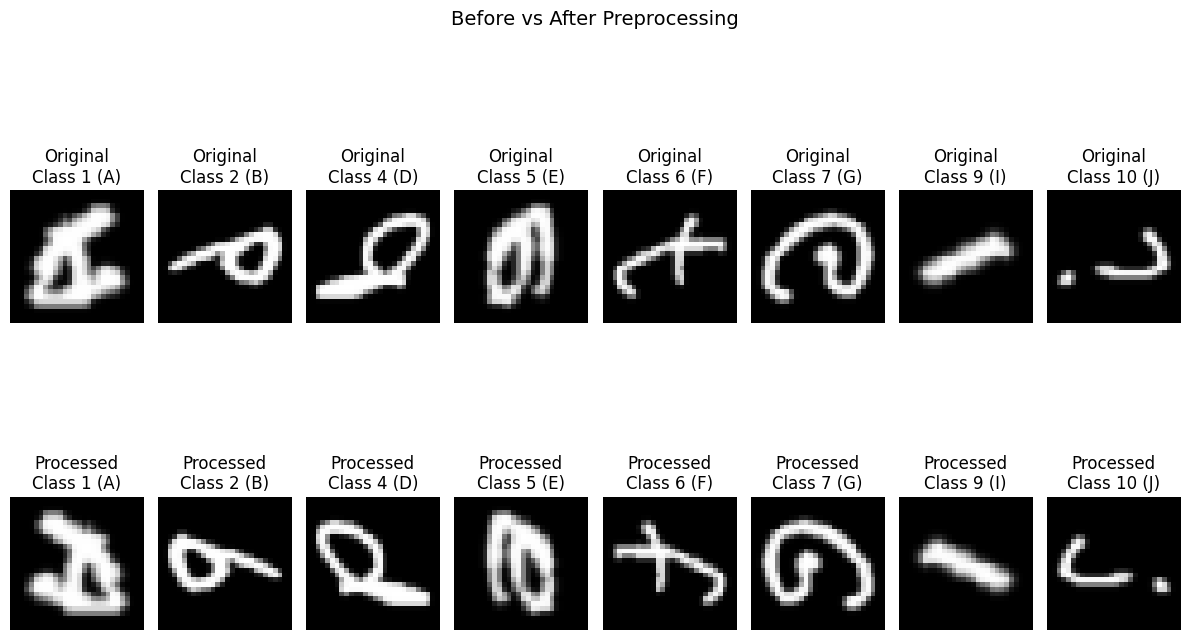


5. Final dataset statistics:
   Final dataset shape: (54589, 785)
   Number of classes: 16
   Classes removed: [-1, -2]
   Images per class:
     Class 1 (A): 3396 samples
     Class 2 (B): 3396 samples
     Class 4 (D): 3398 samples
     Class 5 (E): 3437 samples
     Class 6 (F): 3394 samples
     Class 7 (G): 3385 samples
     Class 9 (I): 3428 samples
     Class 10 (J): 3402 samples
     Class 12 (L): 3415 samples
     Class 14 (N): 3365 samples
     Class 15 (O): 3408 samples
     Class 16 (P): 3430 samples
     Class 17 (Q): 3435 samples
     Class 20 (T): 3436 samples
     Class 24 (X): 3437 samples
     Class 26 (Z): 3427 samples


In [4]:
# Data Cleaning and Preprocessing
def clean_and_preprocess_dataset(data):
    """Clean the dataset by removing blank classes and fixing image orientation"""

    print("=== DATA CLEANING AND PREPROCESSING ===")
    print(f"Original dataset shape: {data.shape}")

    # 1. Remove blank classes (-1 and -2)
    print(f"\n1. Removing blank classes (-1 and -2)...")
    blank_classes = [-1, -2]

    # Show samples before removal
    for blank_class in blank_classes:
        count = len(data[data['label'] == blank_class])
        print(f"   Class {blank_class}: {count} samples (to be removed)")

    # Remove blank classes
    cleaned_data = data[~data['label'].isin(blank_classes)].copy()
    print(f"   Dataset shape after removing blank classes: {cleaned_data.shape}")

    # 2. Fix image orientation (horizontal flip)
    print(f"\n2. Fixing image orientation (horizontal flip)...")

    # Extract pixel columns
    pixel_columns = [col for col in cleaned_data.columns if col.startswith('pixel_')]

    # Function to flip image horizontally
    def flip_image_horizontal(pixel_row):
        # Reshape to 28x28, flip horizontally, then flatten back
        image = pixel_row.values.reshape(28, 28)
        flipped_image = np.fliplr(image)  # Flip left-right
        return flipped_image.flatten()

    # Apply horizontal flip to all images
    print("   Applying horizontal flip to all images...")
    flipped_pixels = cleaned_data[pixel_columns].apply(flip_image_horizontal, axis=1, result_type='expand')

    # Replace pixel columns with flipped versions
    cleaned_data[pixel_columns] = flipped_pixels

    # 3. Update label mapping for alphabetical order
    print(f"\n3. Creating proper label mapping...")

    # Get unique labels (should be 1, 2, 4, 5, 6, 7, 9, 10, 12, 14, 15, 16, 17, 20, 24, 26)
    remaining_labels = sorted(cleaned_data['label'].unique())
    print(f"   Remaining classes: {remaining_labels}")

    # Create mapping to letters (A=1, B=2, C=3, etc., skipping missing letters)
    letter_mapping = {}
    for i in range(1, 27):
        letter = chr(ord('A') + i - 1)  # Convert to letters A, B, C, etc.
        letter_mapping[i] = letter

    print(f"   Label to Letter mapping: {letter_mapping}")

    # 4. Visualize samples after preprocessing
    print(f"\n4. Visualizing samples after preprocessing...")

    # Show before and after comparison for a few samples
    def compare_before_after(original_data, cleaned_data, n_samples=8):
        fig, axes = plt.subplots(2, n_samples, figsize=(12, 8))
        fig.suptitle('Before vs After Preprocessing', fontsize=14)

        # Select samples that exist in both datasets
        common_labels = [label for label in remaining_labels[:n_samples]]

        for i, label in enumerate(common_labels):
            # Original (before cleaning)
            orig_sample = original_data[original_data['label'] == label].iloc[0]
            orig_pixels = orig_sample[pixel_columns].values.reshape(28, 28)

            # Cleaned (after preprocessing)
            clean_sample = cleaned_data[cleaned_data['label'] == label].iloc[0]
            clean_pixels = clean_sample[pixel_columns].values.reshape(28, 28)

            # Plot original
            axes[0, i].imshow(orig_pixels, cmap='gray')
            axes[0, i].set_title(f'Original\nClass {label} ({letter_mapping[label]})')
            axes[0, i].axis('off')

            # Plot cleaned
            axes[1, i].imshow(clean_pixels, cmap='gray')
            axes[1, i].set_title(f'Processed\nClass {label} ({letter_mapping[label]})')
            axes[1, i].axis('off')

        plt.tight_layout()
        plt.show()

    # Show comparison
    compare_before_after(data, cleaned_data, n_samples=8)

    # 5. Final statistics
    print(f"\n5. Final dataset statistics:")
    print(f"   Final dataset shape: {cleaned_data.shape}")
    print(f"   Number of classes: {len(remaining_labels)}")
    print(f"   Classes removed: {blank_classes}")
    print(f"   Images per class:")

    class_distribution = cleaned_data['label'].value_counts().sort_index()
    for label, count in class_distribution.items():
        letter = letter_mapping[label]
        print(f"     Class {label} ({letter}): {count} samples")

    # map labels to letters
    cleaned_data['label'] = cleaned_data['label'].map(letter_mapping)

    return cleaned_data, letter_mapping

# Apply cleaning and preprocessing
cleaned_data, letter_mapping = clean_and_preprocess_dataset(data)

#### After Preprocessing Observation

After applying the initial preprocessing steps (horizontal flipping and relabeling the classes), we made an additional observation:

- **Rotated Letters**  
  - All the characters are still **rotated sideways**.
  - To correct this, we need to **rotate each image by 90 degrees anti-clockwise** so that the letters are properly upright.

---

#### Updated Preprocessing Steps

1. **Remove Blank Images** (`Class -1` and `Class -2`)
2. **Relabel Classes** (Class `1` = `A`, Class `2` = `B`, ...)
3. **Flip Images Horizontally** (to fix mirrored effect)
4. **Rotate Images 90° Anti-Clockwise** (to orient characters correctly)

This ensures the images are in the correct visual format before we apply any further augmentation or training.


=== ROTATING IMAGES 90° ANTI-CLOCKWISE ===
Dataset shape before rotation: (54589, 785)
   Applying 90° anti-clockwise rotation to all images...
   Visualizing before vs after rotation...


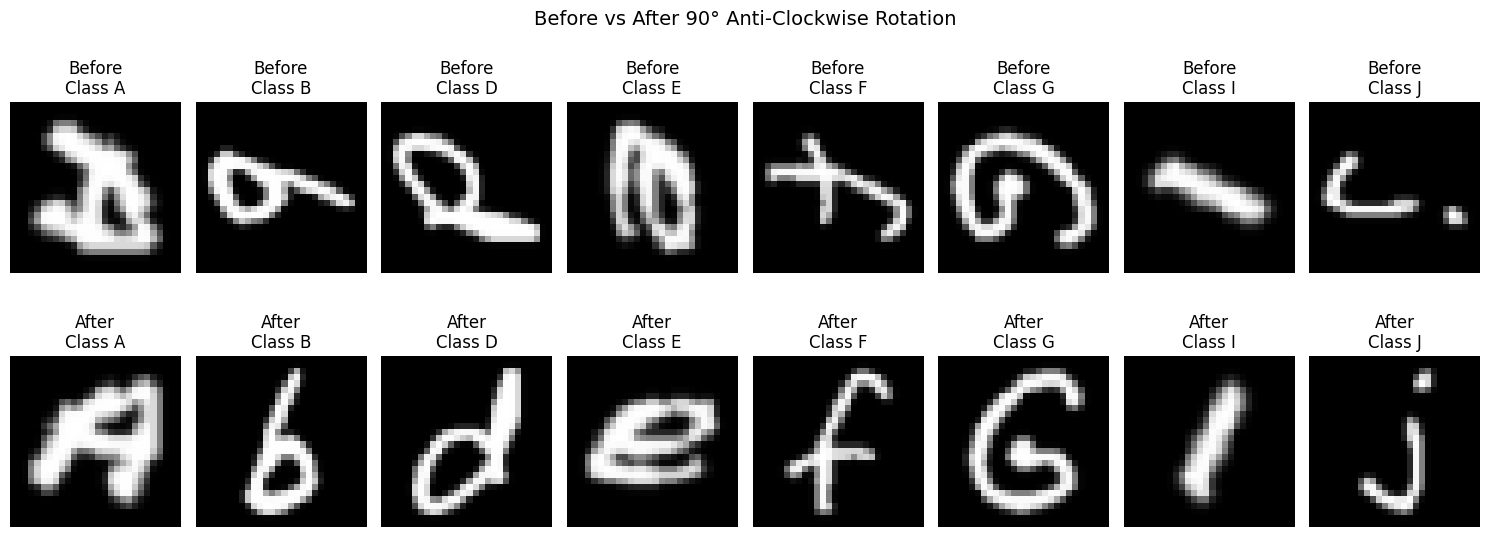

   Final dataset shape after rotation: (54589, 785)
   Rotation completed successfully!


In [5]:
# Rotate all images 90 degrees anti-clockwise
def rotate_images_90_anticlockwise(data):
    """Rotate all images in the dataset 90 degrees anti-clockwise"""

    print("=== ROTATING IMAGES 90° ANTI-CLOCKWISE ===")
    print(f"Dataset shape before rotation: {data.shape}")

    # Extract pixel columns
    pixel_columns = [col for col in data.columns if col.startswith('pixel_')]

    def rotate_image_90_anticlockwise(pixel_row):
        # Reshape to 28x28, rotate 90° anti-clockwise, then flatten back
        image = pixel_row.values.reshape(28, 28)
        rotated_image = np.rot90(image, k=1)  # k=1 means 90° counter-clockwise
        return pd.Series(rotated_image.flatten())

    # Apply rotation to all images
    print("   Applying 90° anti-clockwise rotation to all images...")
    rotated_pixels = data[pixel_columns].apply(rotate_image_90_anticlockwise, axis=1, result_type='expand')
    rotated_pixels = rotated_pixels.astype(np.float32)  # Ensure pixel values are float32

    # Create a copy of the data and replace pixel columns with rotated versions
    rotated_data = data.copy()
    rotated_data[pixel_columns] = rotated_pixels

    # Visualize before and after comparison
    print("   Visualizing before vs after rotation...")

    def compare_rotation(original_data, rotated_data, n_samples=8):
        fig, axes = plt.subplots(2, n_samples, figsize=(15, 6))
        fig.suptitle('Before vs After 90° Anti-Clockwise Rotation', fontsize=14)

        # Select sample labels to visualize
        sample_labels = sorted(original_data['label'].unique())[:n_samples]

        for i, label in enumerate(sample_labels):
            if label in original_data['label'].values:
                # Original (before rotation)
                orig_sample = original_data[original_data['label'] == label].iloc[0]
                orig_pixels = orig_sample[pixel_columns].values.astype(np.float32).reshape(28, 28)

                # Rotated (after rotation)
                rot_sample = rotated_data[rotated_data['label'] == label].iloc[0]
                rot_pixels = rot_sample[pixel_columns].values.astype(np.float32).reshape(28, 28)

                # Plot original
                axes[0, i].imshow(orig_pixels, cmap='gray')
                axes[0, i].set_title(f'Before\nClass {label}')
                axes[0, i].axis('off')

                # Plot rotated
                axes[1, i].imshow(rot_pixels, cmap='gray')
                axes[1, i].set_title(f'After\nClass {label}')
                axes[1, i].axis('off')
            else:
                axes[0, i].axis('off')
                axes[1, i].axis('off')

        plt.tight_layout()
        plt.show()

    # Show comparison
    compare_rotation(data, rotated_data, n_samples=8)

    print(f"   Final dataset shape after rotation: {rotated_data.shape}")
    print("   Rotation completed successfully!")

    return rotated_data

# Apply rotation to the cleaned data
rotated_data = rotate_images_90_anticlockwise(cleaned_data)



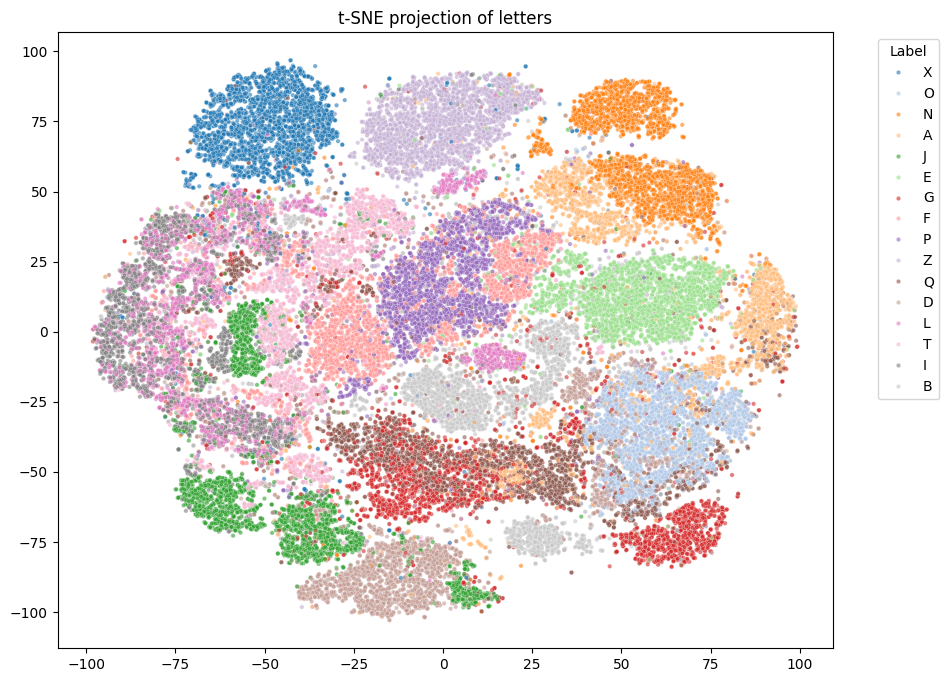

In [6]:
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
pixel_columns = [f'pixel_{i}' for i in range(784)]
# Flatten pixel data
X_flat = rotated_data[pixel_columns].values
labels = rotated_data['label'].values

# Reduce to 2D for visualization
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_flat)

# Plot
plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=labels, palette='tab20', s=10, alpha=0.6)
plt.title("t-SNE projection of letters")
plt.legend(title="Label", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


Label A: Found 43 potential outliers
Label B: Found 35 potential outliers
Label D: Found 0 potential outliers
Label E: Found 12 potential outliers
Label F: Found 0 potential outliers
Label G: Found 77 potential outliers
Label I: Found 0 potential outliers
Label J: Found 0 potential outliers
Label L: Found 0 potential outliers
Label N: Found 11 potential outliers
Label O: Found 0 potential outliers
Label P: Found 14 potential outliers
Label Q: Found 40 potential outliers
Label T: Found 26 potential outliers
Label X: Found 13 potential outliers
Label Z: Found 12 potential outliers

=== t-SNE + DBSCAN: VISUALIZING ALL 283 OUTLIERS ===

Label A: 43 outliers


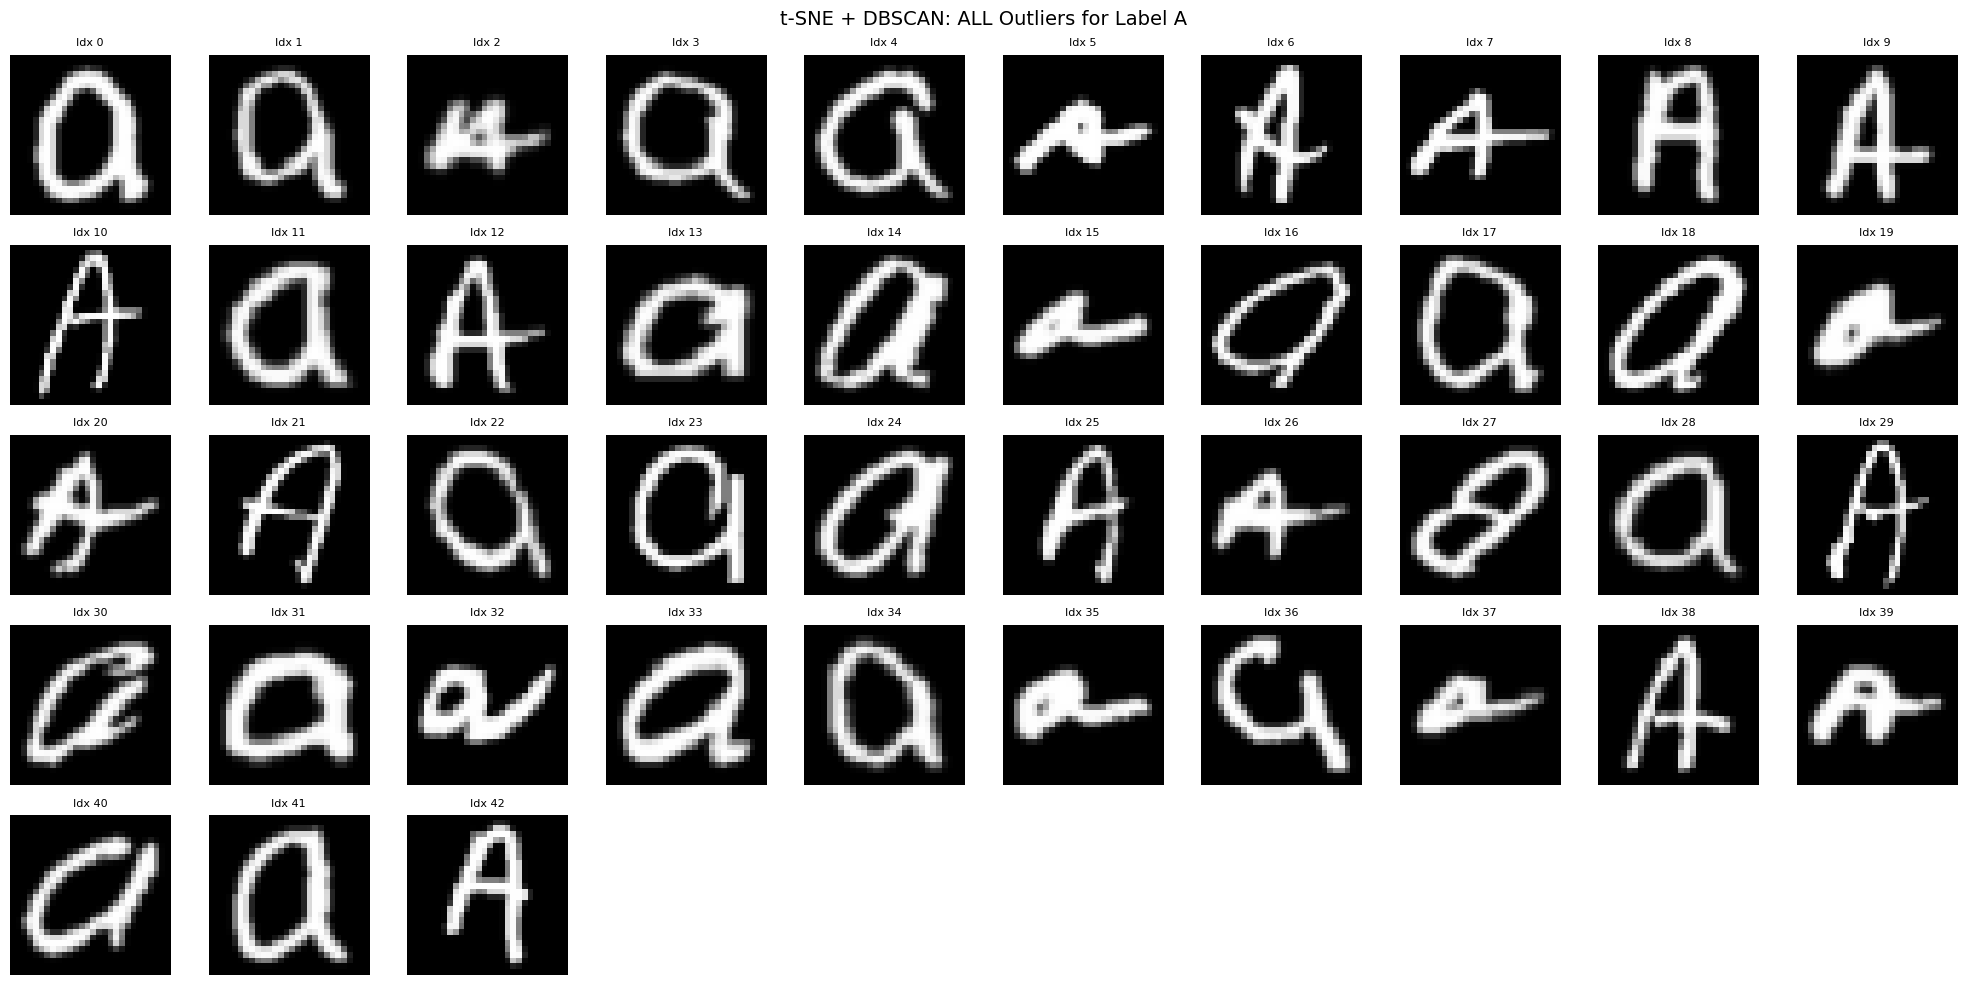


Label B: 35 outliers


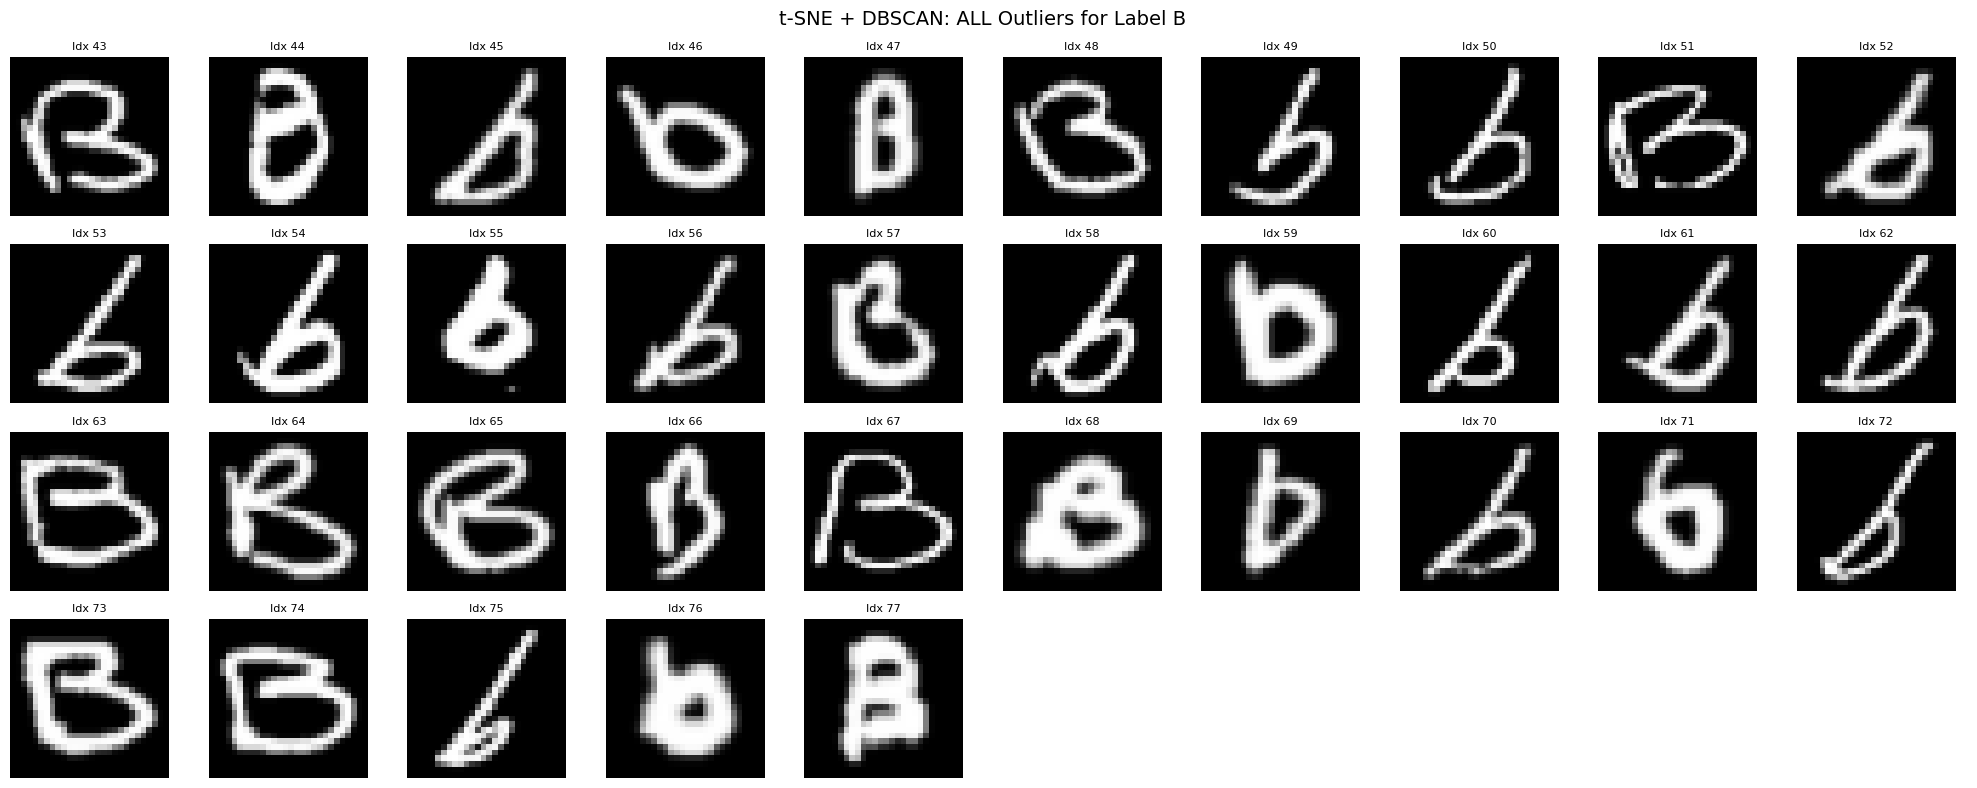


Label E: 12 outliers


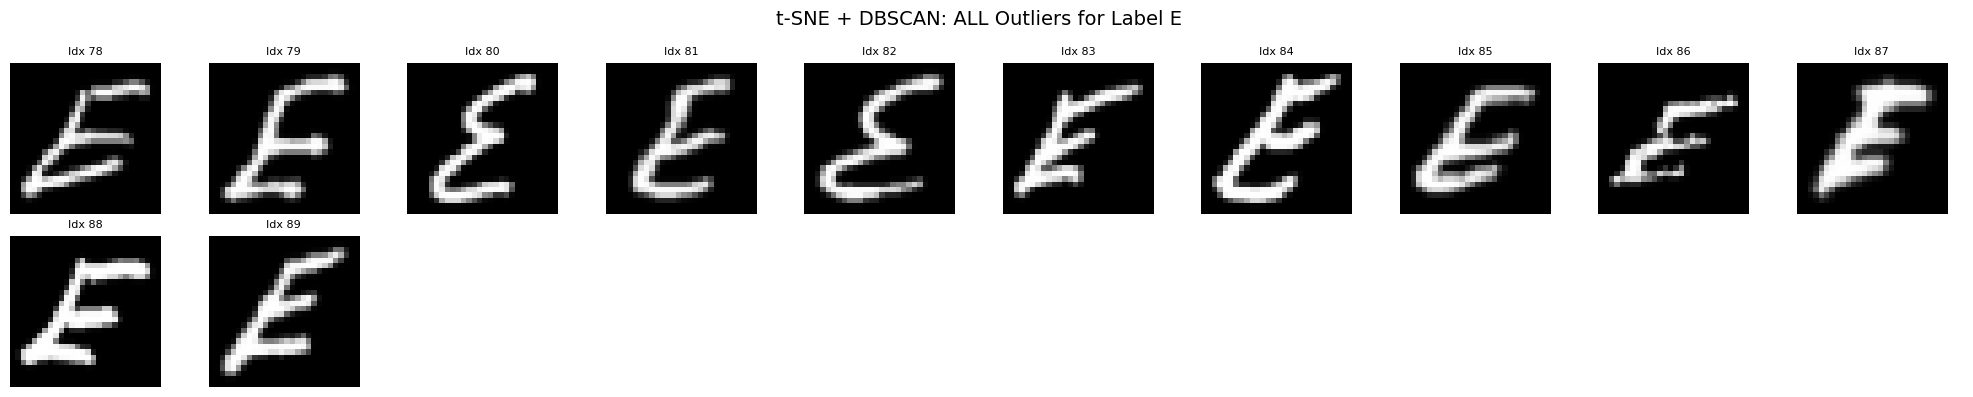


Label G: 77 outliers


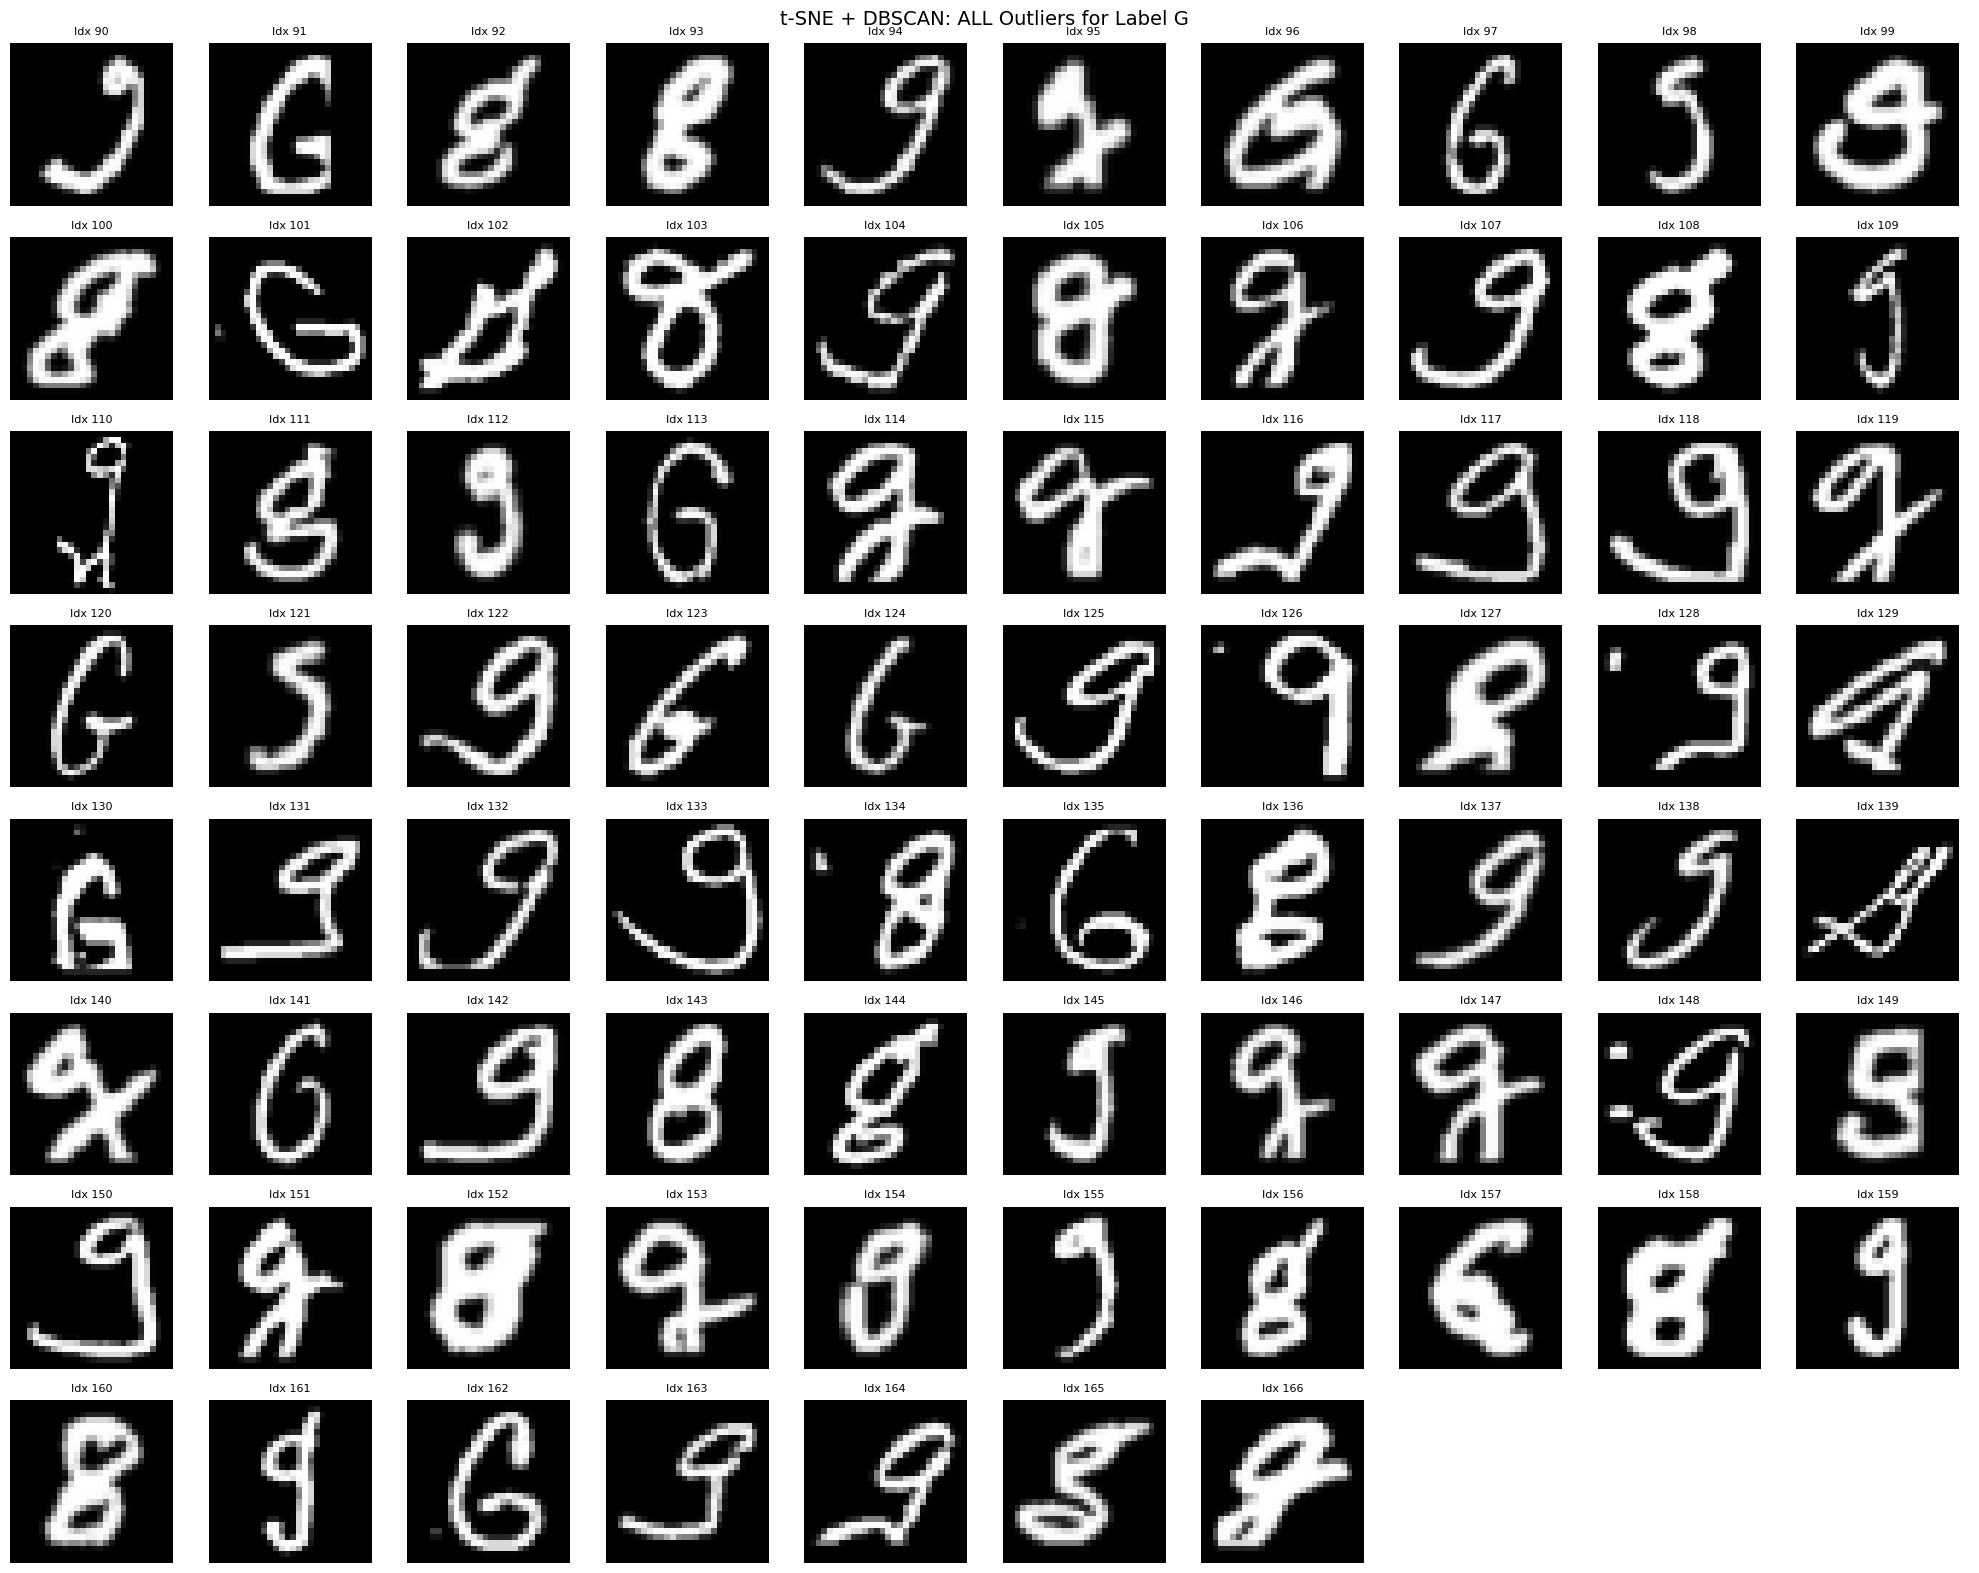


Label N: 11 outliers


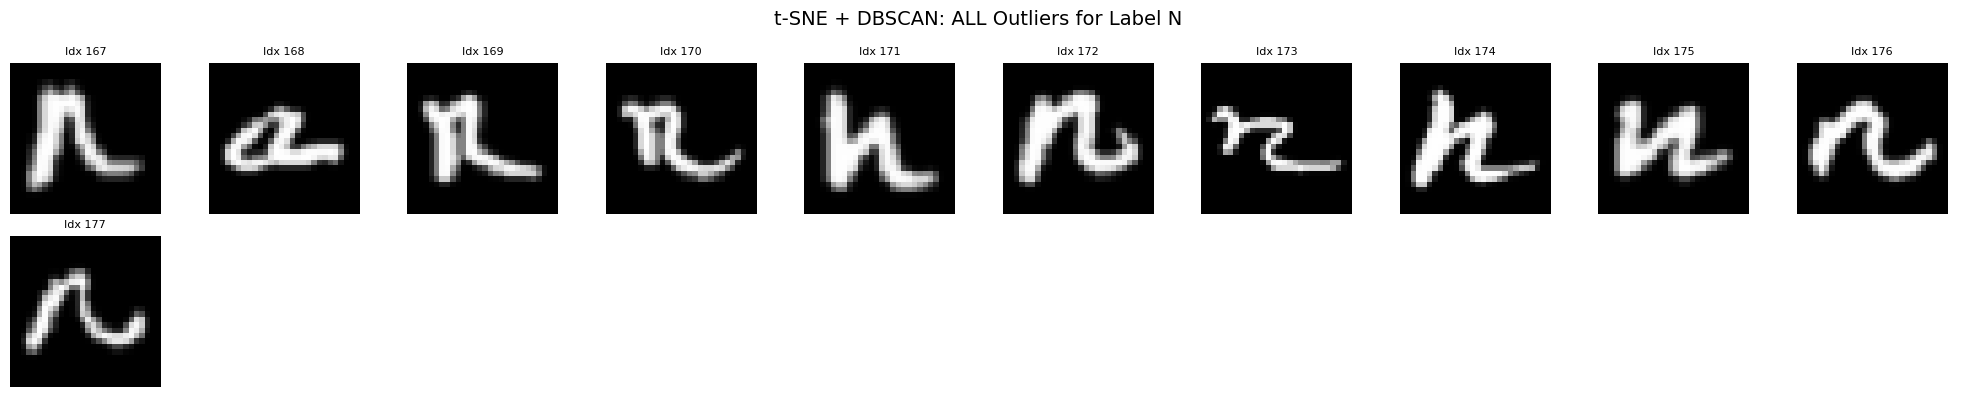


Label P: 14 outliers


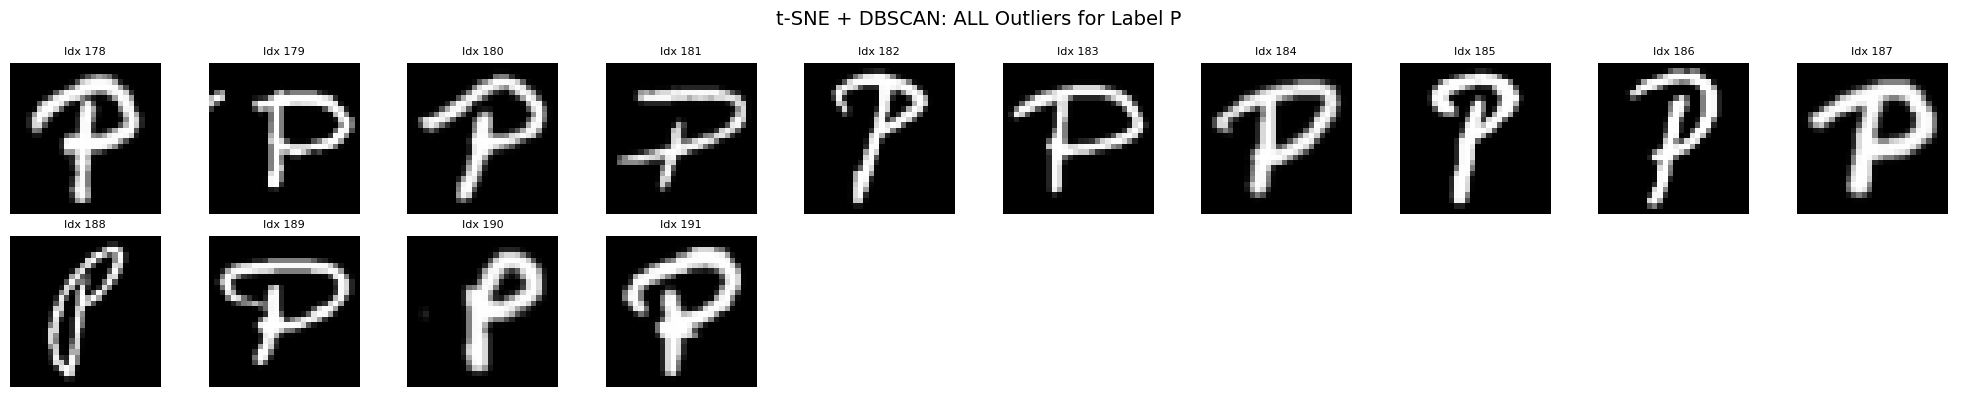


Label Q: 40 outliers


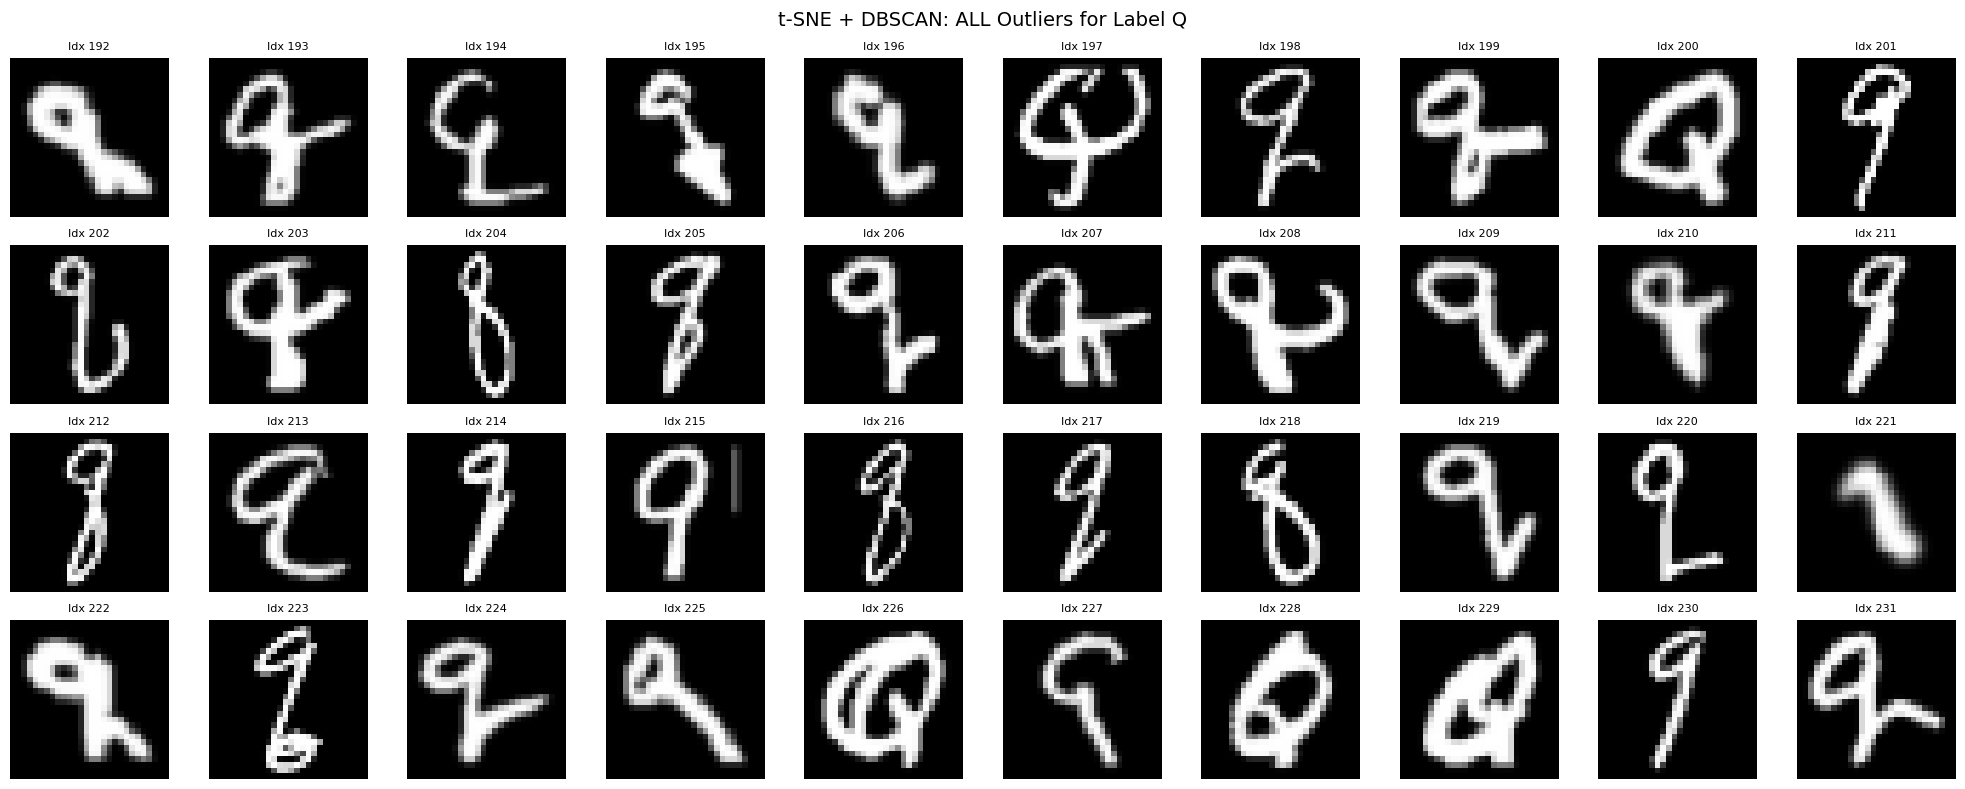


Label T: 26 outliers


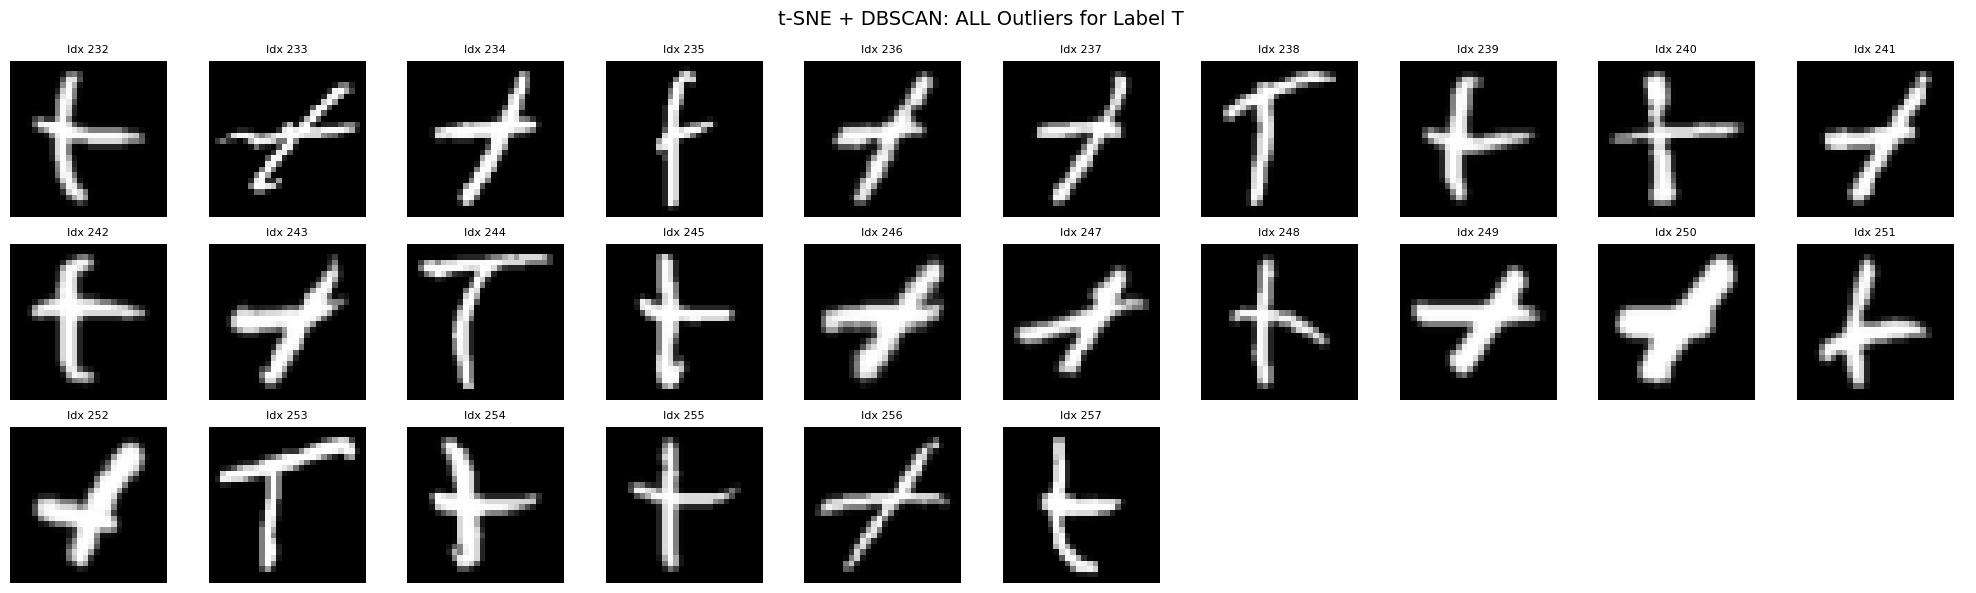


Label X: 13 outliers


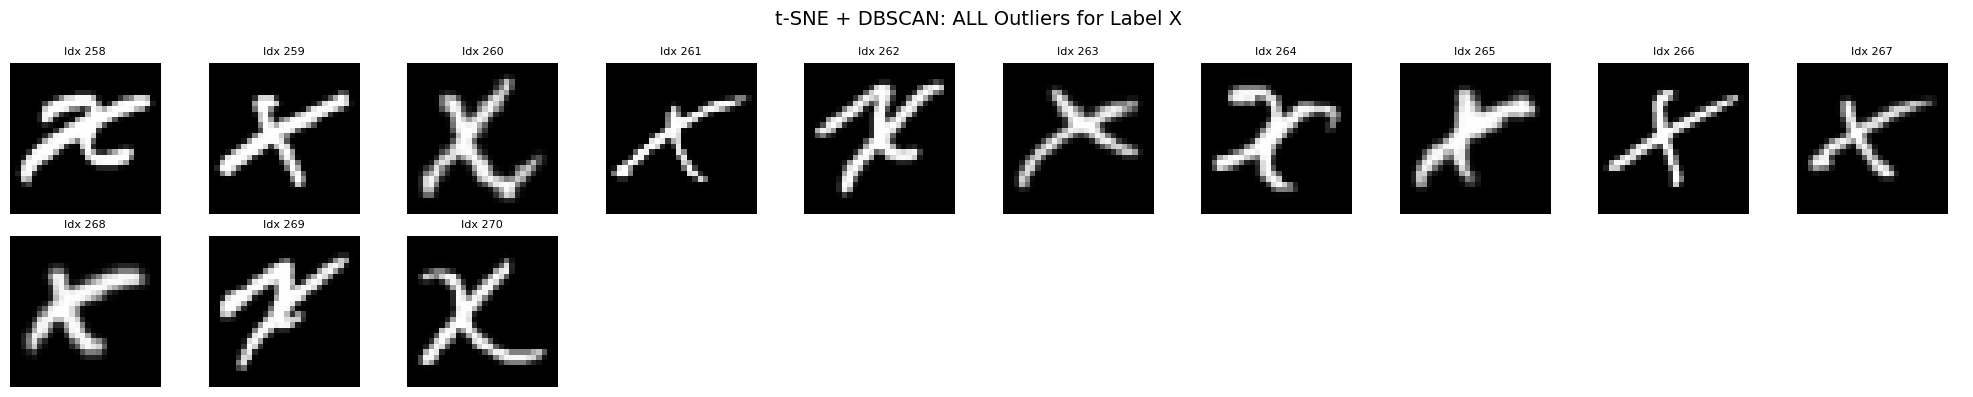


Label Z: 12 outliers


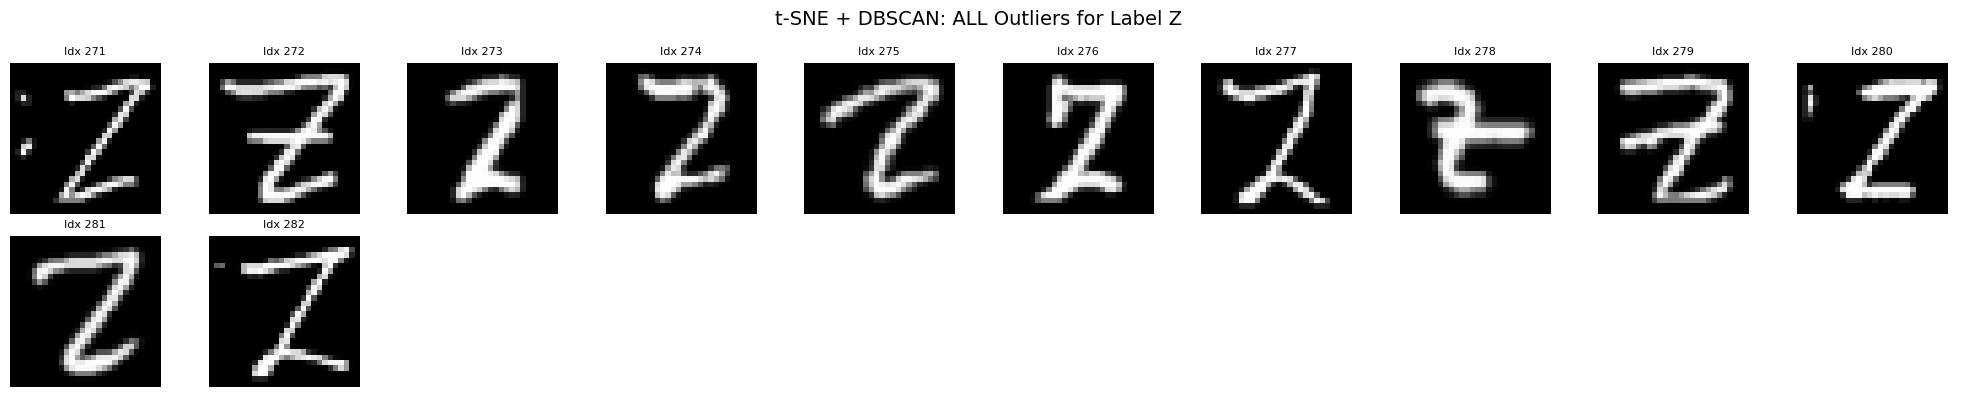

In [11]:
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Prepare t-SNE input
X_flat = rotated_data[pixel_columns].values
labels = rotated_data['label'].values

# Run t-SNE on entire dataset
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_flat)

# Attach t-SNE results to dataframe
rotated_data['tsne_x'] = X_tsne[:, 0]
rotated_data['tsne_y'] = X_tsne[:, 1]

# Store suspected outliers
outlier_rows = []
tsne_outlier_indices_by_label = {}

# For each label, cluster in t-SNE space
for label in np.unique(labels):
    subset = rotated_data[rotated_data['label'] == label]
    coords = subset[['tsne_x', 'tsne_y']].values

    # DBSCAN: density-based clustering
    dbscan = DBSCAN(eps=5.0, min_samples=10)
    cluster_labels = dbscan.fit_predict(coords)

    # Add to dataframe
    subset = subset.copy()
    subset['tsne_cluster'] = cluster_labels

    # Select outliers (label == -1) or rare clusters
    cluster_counts = subset['tsne_cluster'].value_counts()
    rare_clusters = cluster_counts[cluster_counts < 15].index
    is_outlier = subset['tsne_cluster'].isin(rare_clusters)
    outliers = subset[is_outlier]

    outlier_rows.append(outliers)
    print(f"Label {label}: Found {len(outliers)} potential outliers")

# Combine all outliers
all_tsne_outliers = pd.concat(outlier_rows, ignore_index=True) if outlier_rows else pd.DataFrame()

print(f"\n=== t-SNE + DBSCAN: VISUALIZING ALL {len(all_tsne_outliers)} OUTLIERS ===")

# Function to visualize ALL outliers for each label
def visualize_all_outliers_tsne(df, pixel_columns, max_per_row=10):
    if df.empty:
        print("No outliers found!")
        return

    labels = sorted(df['label'].unique())

    for label in labels:
        subset = df[df['label'] == label]
        if len(subset) == 0:
            continue

        print(f"\nLabel {label}: {len(subset)} outliers")

        # Calculate grid dimensions
        n_outliers = len(subset)
        n_rows = (n_outliers + max_per_row - 1) // max_per_row
        n_cols = min(max_per_row, n_outliers)

        fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*2, n_rows*2))

        # Handle single row/column cases
        if n_rows == 1 and n_cols == 1:
            axes = [axes]
        elif n_rows == 1:
            axes = axes.reshape(1, -1)
        elif n_cols == 1:
            axes = axes.reshape(-1, 1)

        # Plot each outlier
        for i, (_, row) in enumerate(subset.iterrows()):
            row_idx = i // max_per_row
            col_idx = i % max_per_row

            img = row[pixel_columns].values.astype(np.float32).reshape(28, 28)

            if n_rows == 1:
                ax = axes[col_idx]
            else:
                ax = axes[row_idx, col_idx]

            ax.imshow(img, cmap='gray')
            ax.set_title(f"Idx {row.name}", fontsize=8)
            ax.axis('off')

        # Hide unused subplots
        total_subplots = n_rows * n_cols
        for i in range(n_outliers, total_subplots):
            row_idx = i // max_per_row
            col_idx = i % max_per_row
            if n_rows == 1:
                axes[col_idx].axis('off')
            else:
                axes[row_idx, col_idx].axis('off')

        plt.suptitle(f"t-SNE + DBSCAN: ALL Outliers for Label {label}", fontsize=14)
        plt.tight_layout()
        plt.show()

# Visualize all outliers
visualize_all_outliers_tsne(all_tsne_outliers, pixel_columns)

### Outliers detection with IsolationForest


Anomaly Detection: Isolation-based Approach

This method focuses on identifying anomalies based on how easily they can be "isolated" from the rest of the data points.

* **Global Approach:** The algorithm operates directly on the raw data in its full 784-dimensional pixel space, without any dimensionality reduction. This makes it a "global" approach, considering all features simultaneously.

* **Contamination Parameter:** We assume that **1% of the data are outliers**, which is specified by the `contamination` parameter set to `0.01`. This value helps the model to set a threshold for what constitutes an anomaly.

* **Efficiency:** The key advantage of this method is its speed. It's **faster** than many other techniques because it doesn't require any time-consuming dimensionality reduction steps.

=== ISOLATION FOREST: FINDING AND VISUALIZING ALL OUTLIERS ===
Label A: Found 34 outliers out of 3396 samples.


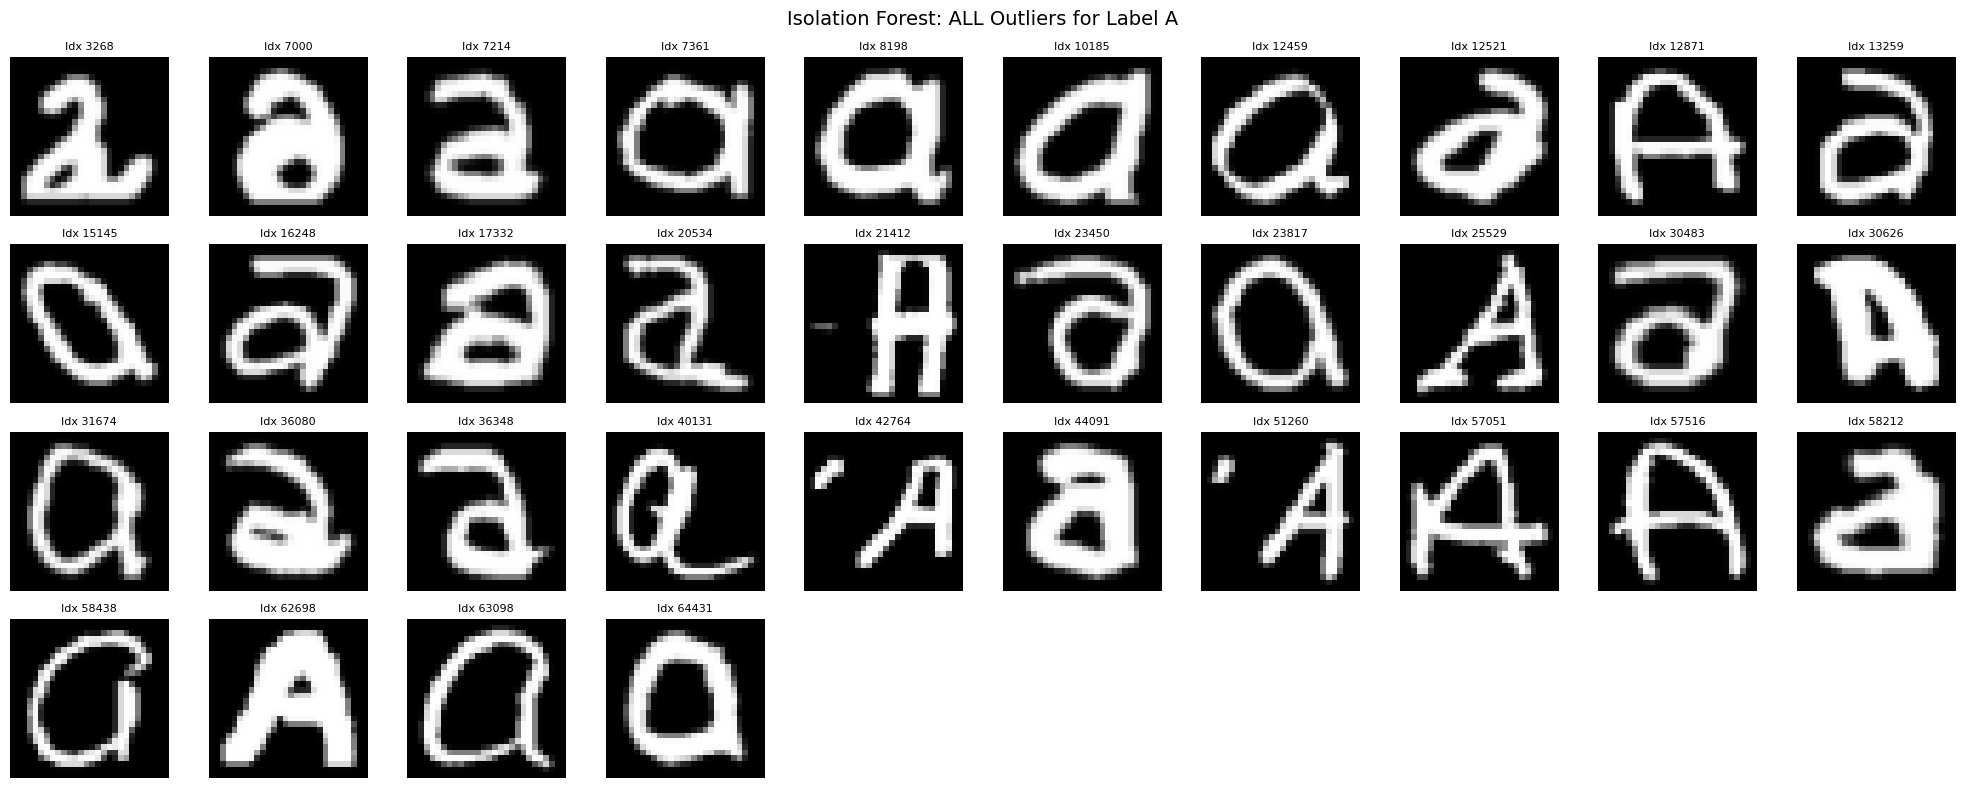

Label B: Found 34 outliers out of 3396 samples.


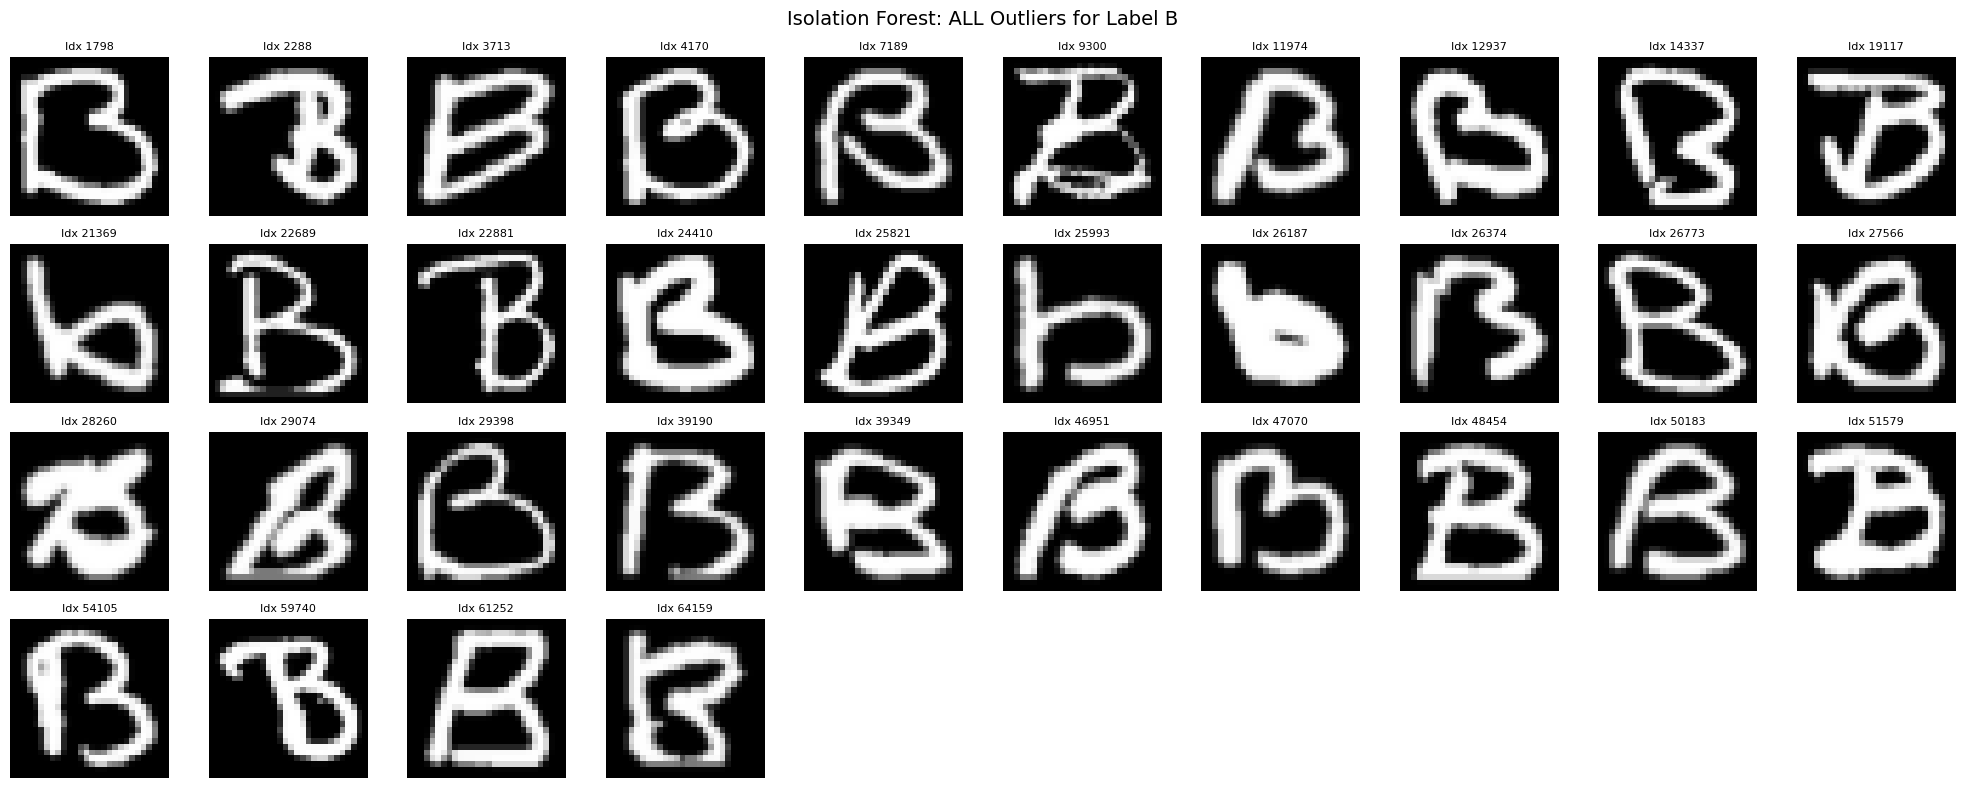

Label D: Found 34 outliers out of 3398 samples.


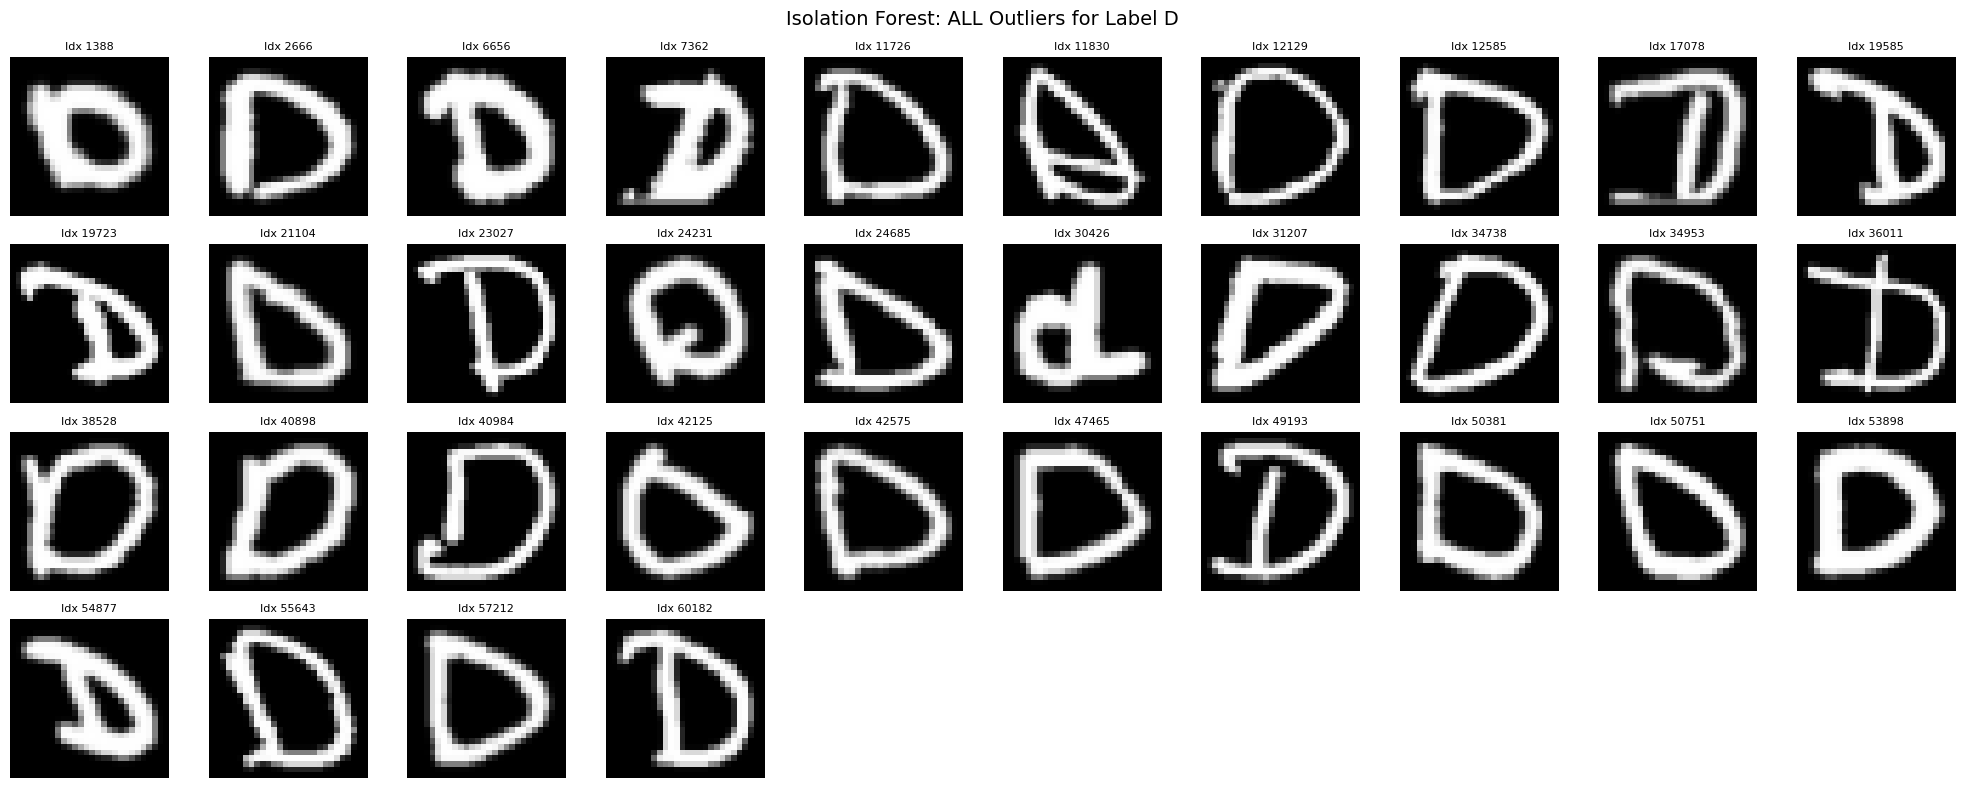

Label E: Found 35 outliers out of 3437 samples.


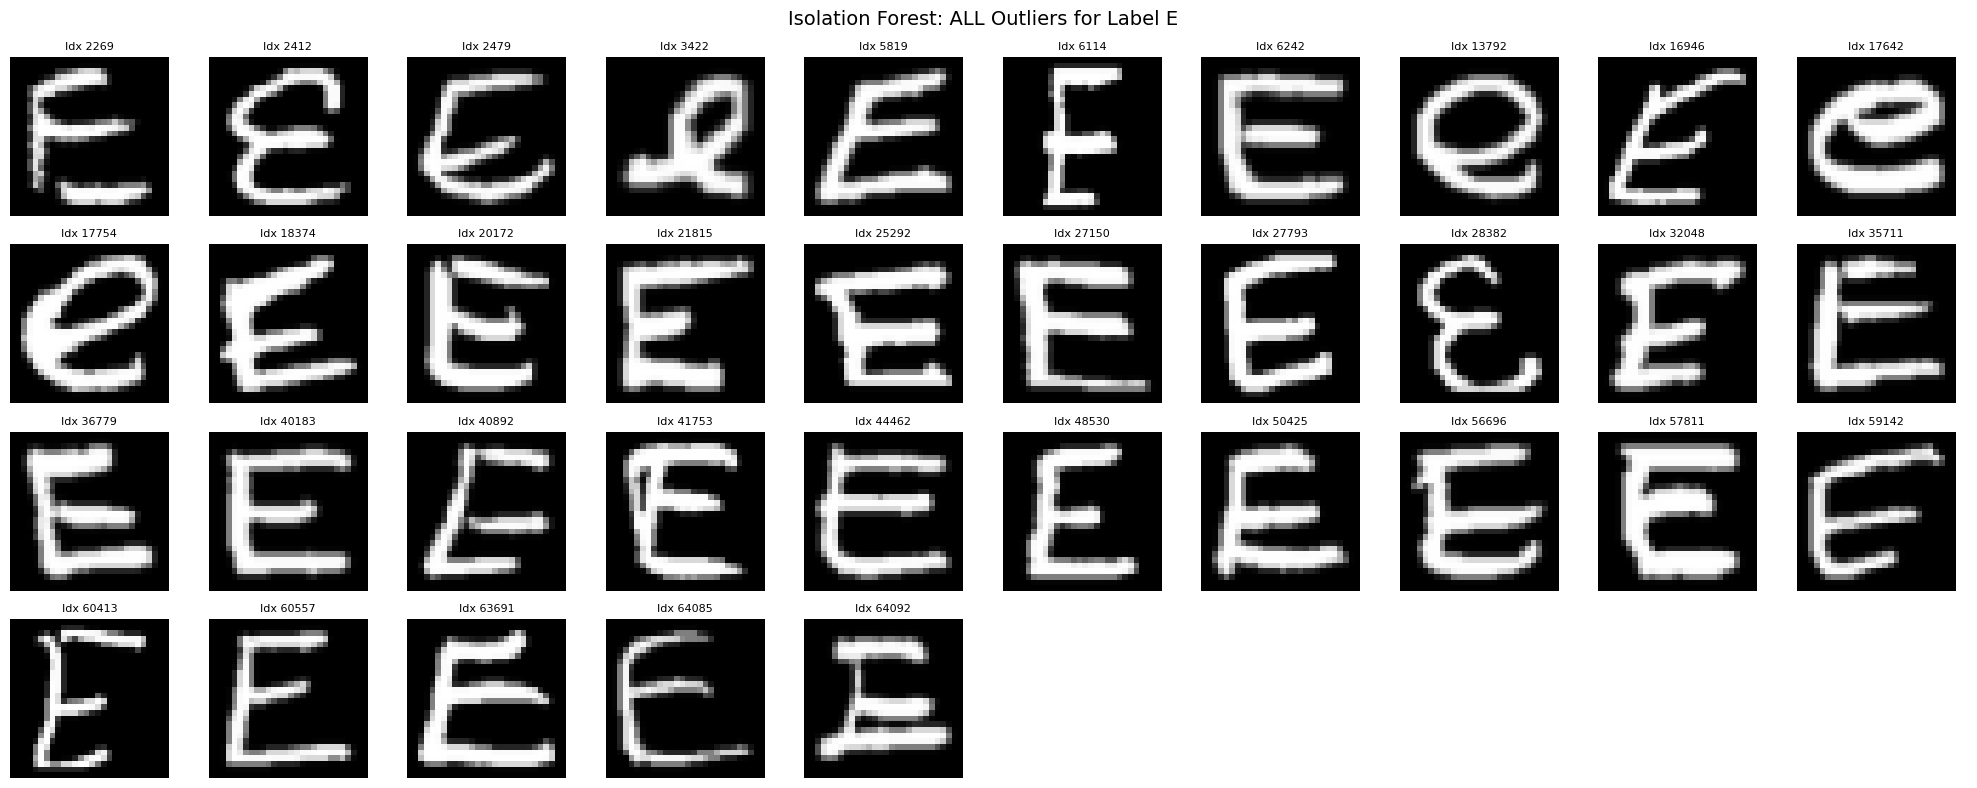

Label F: Found 34 outliers out of 3394 samples.


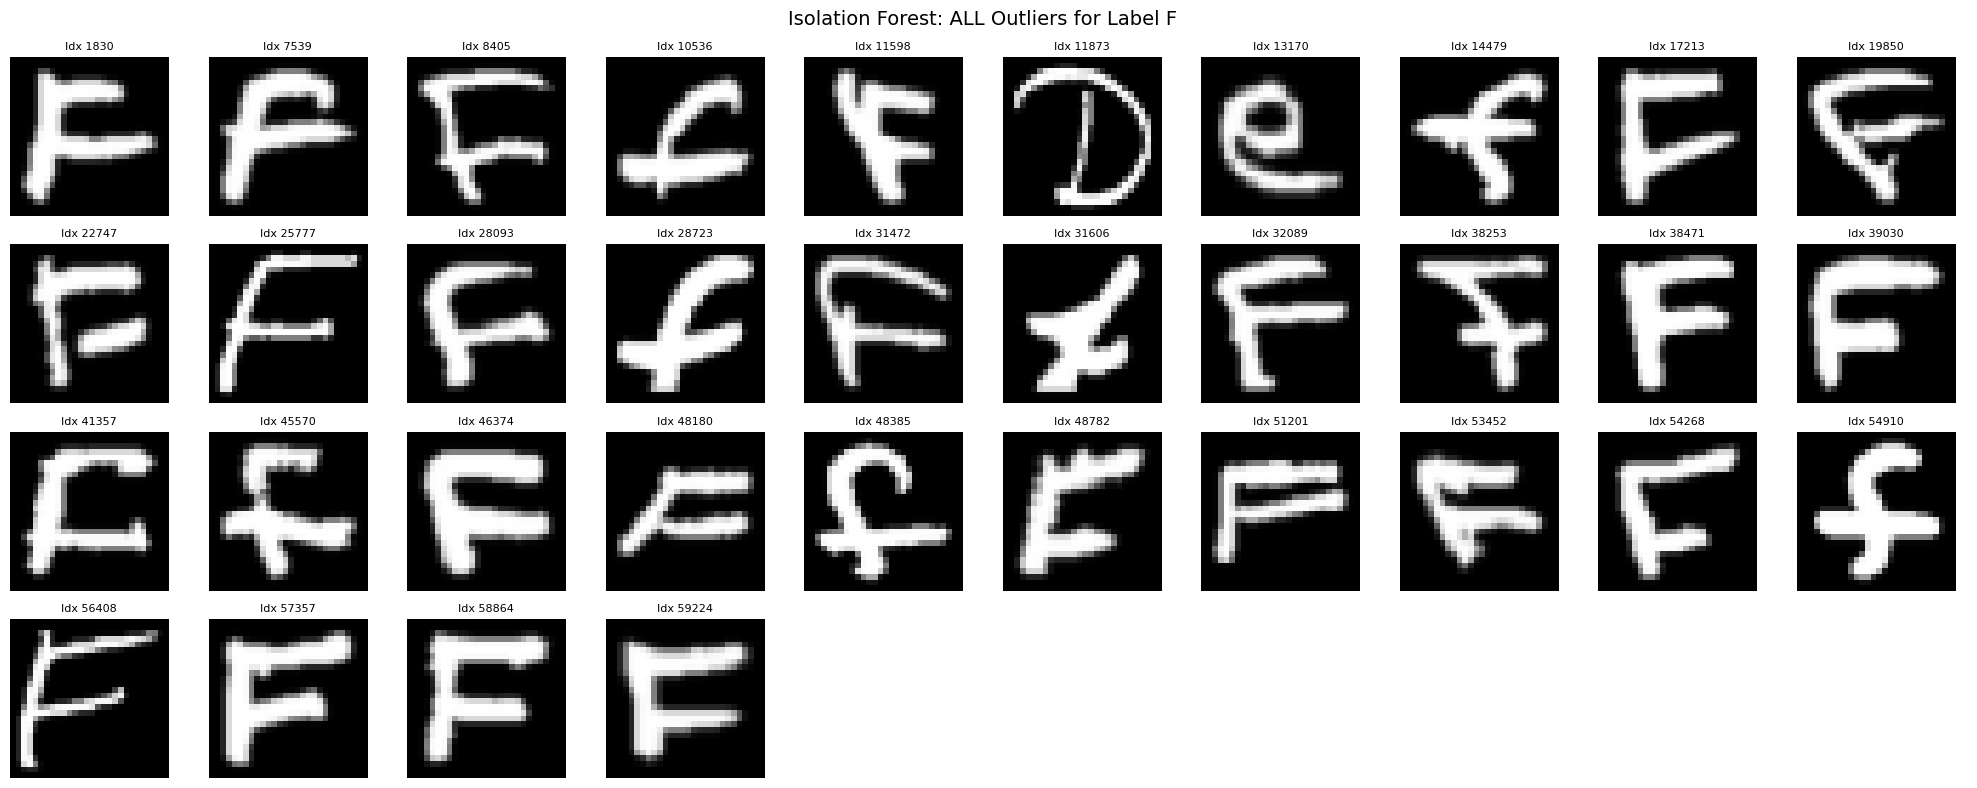

Label G: Found 34 outliers out of 3385 samples.


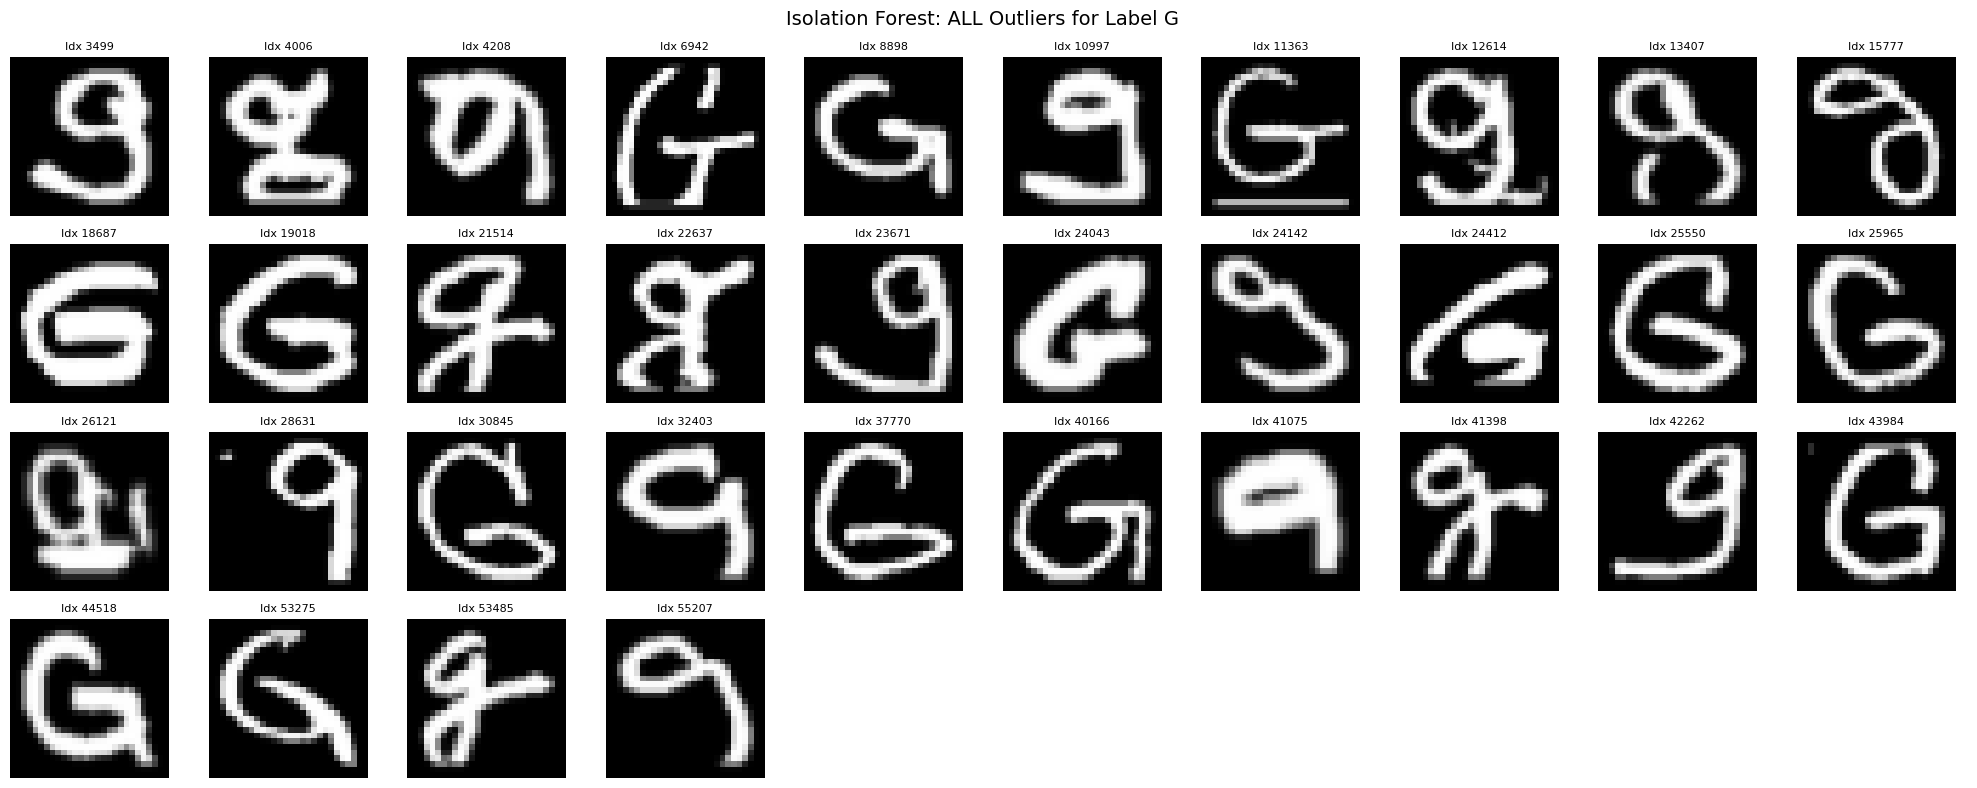

Label I: Found 35 outliers out of 3428 samples.


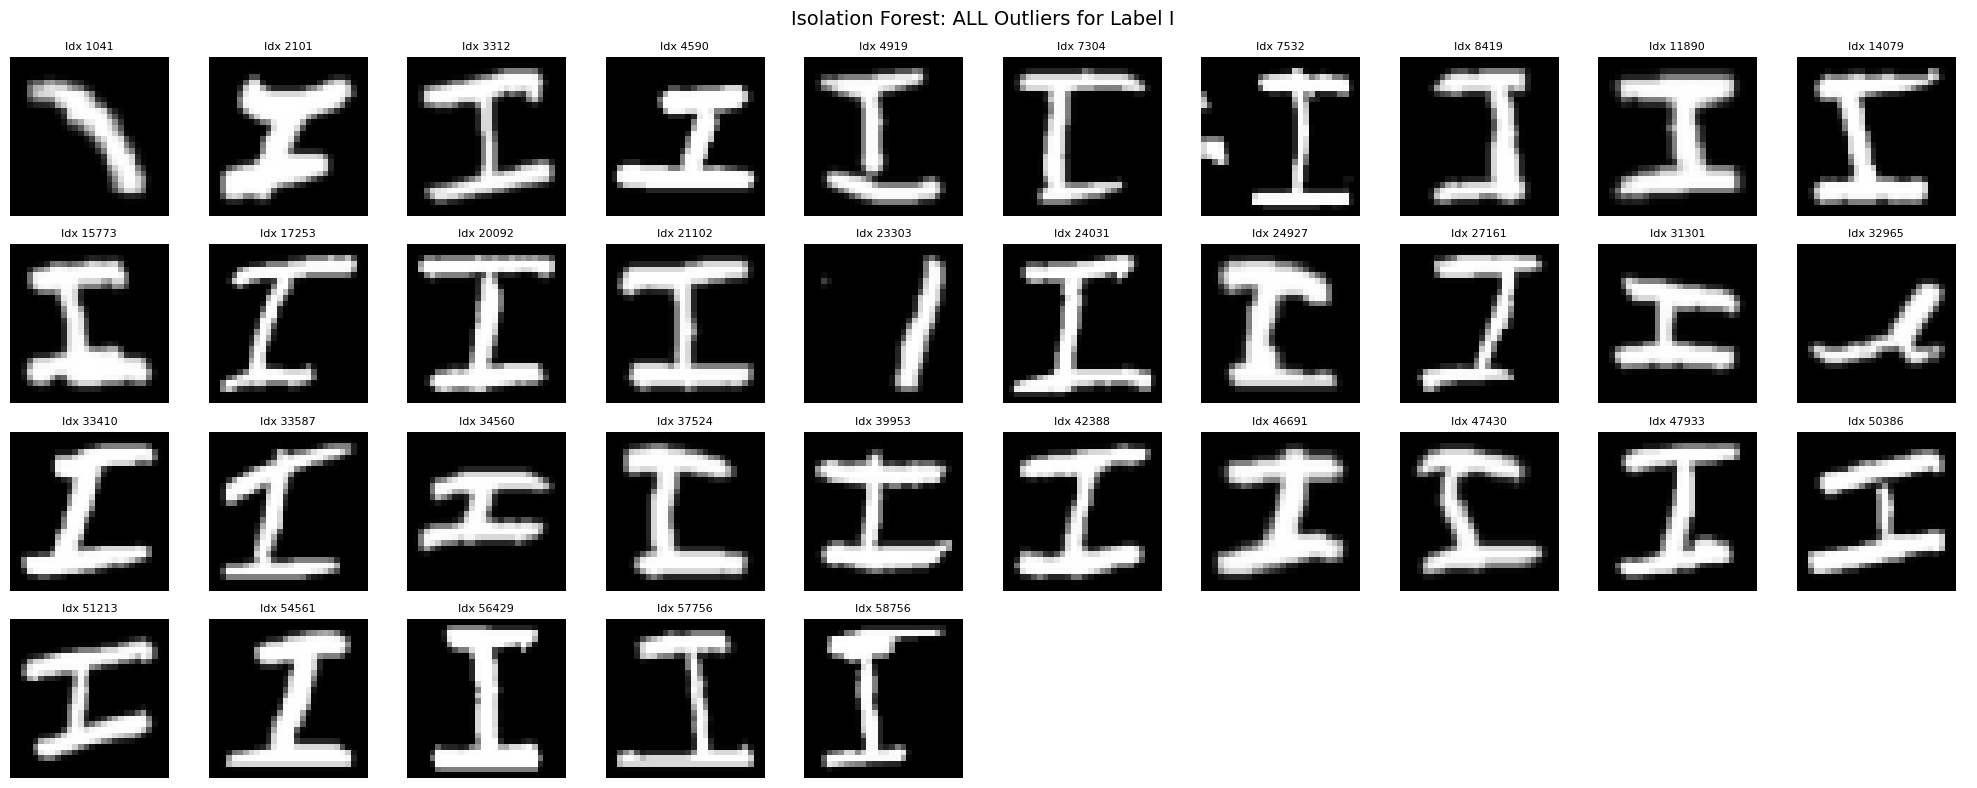

Label J: Found 35 outliers out of 3402 samples.


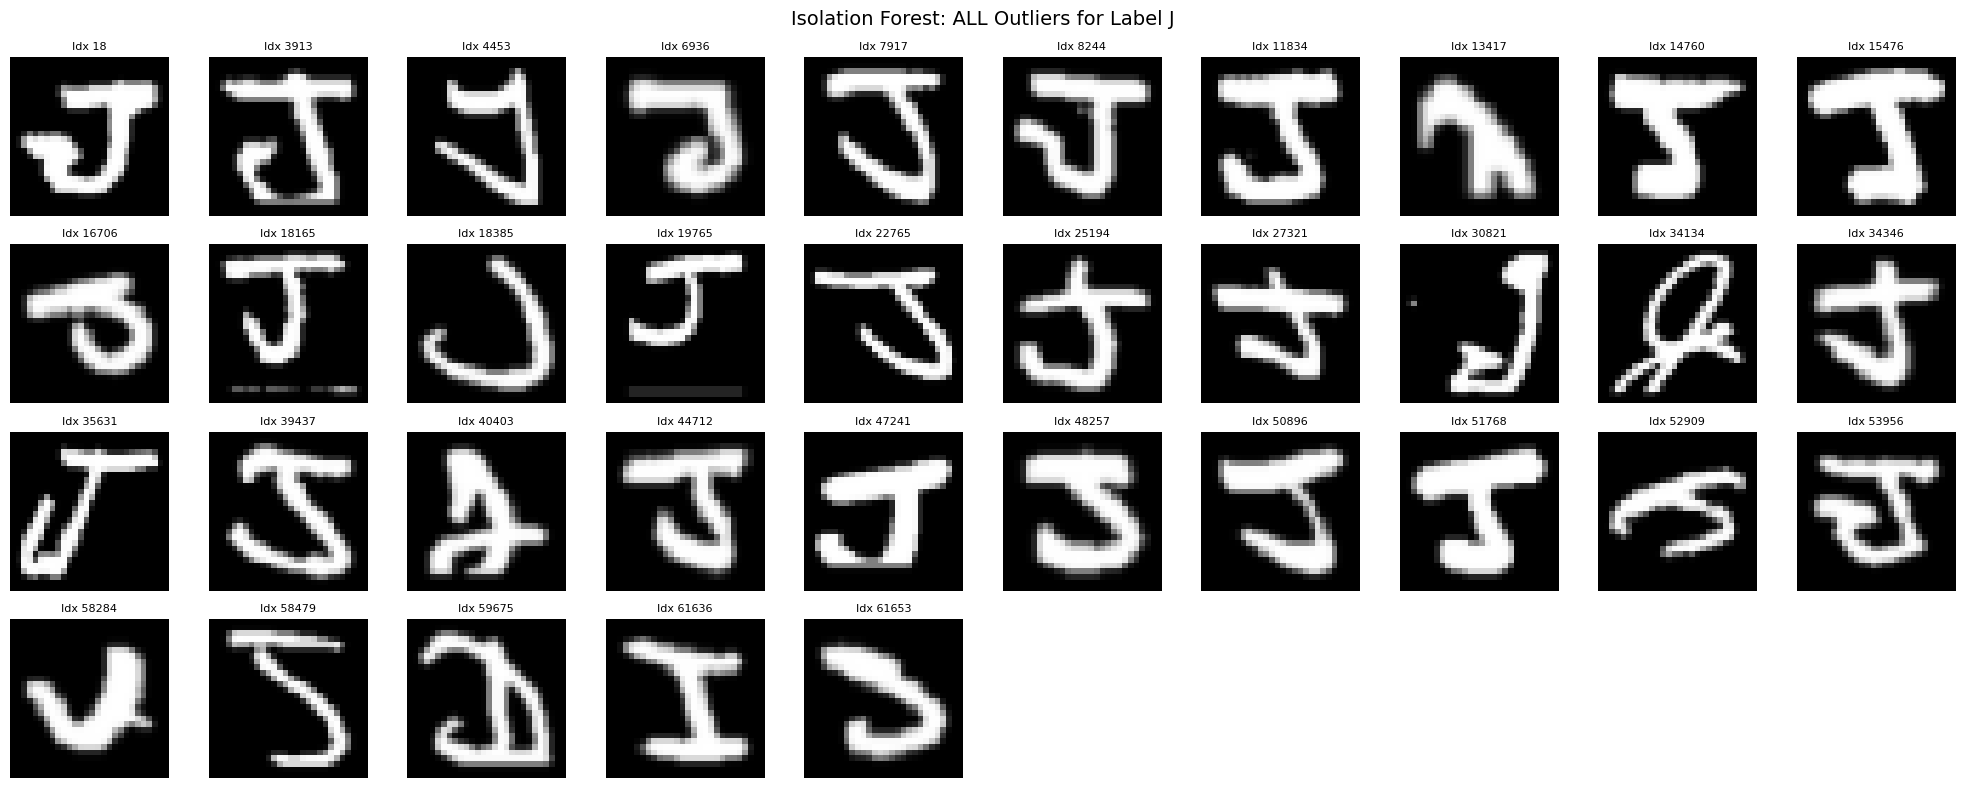

Label L: Found 35 outliers out of 3415 samples.


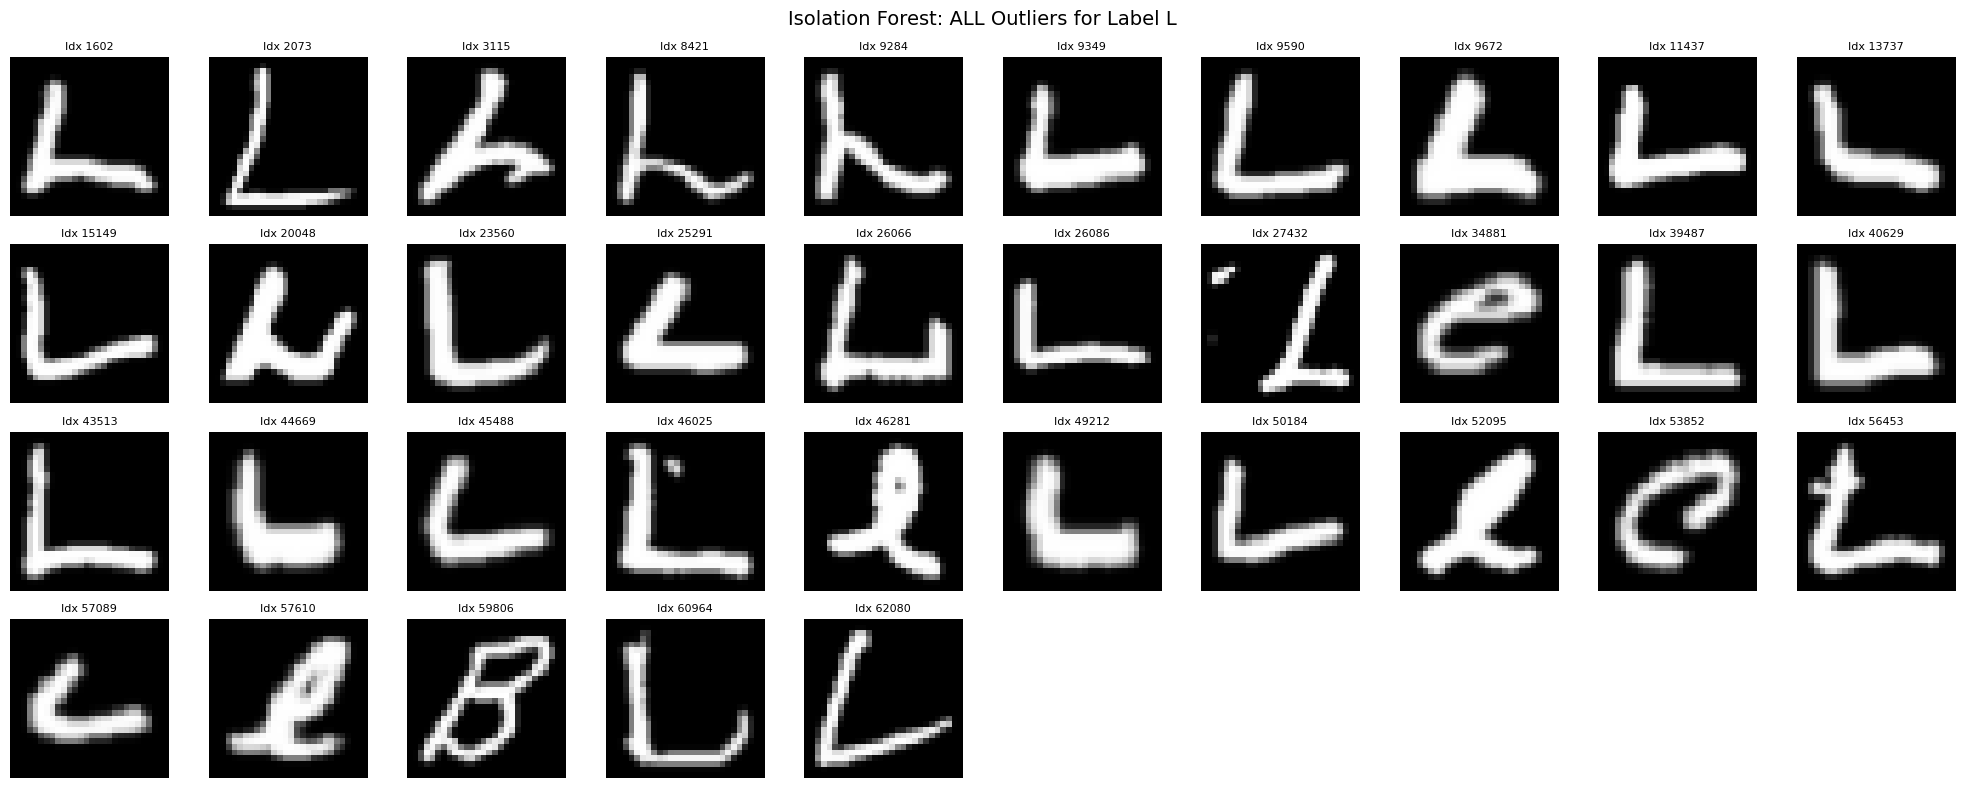

Label N: Found 34 outliers out of 3365 samples.


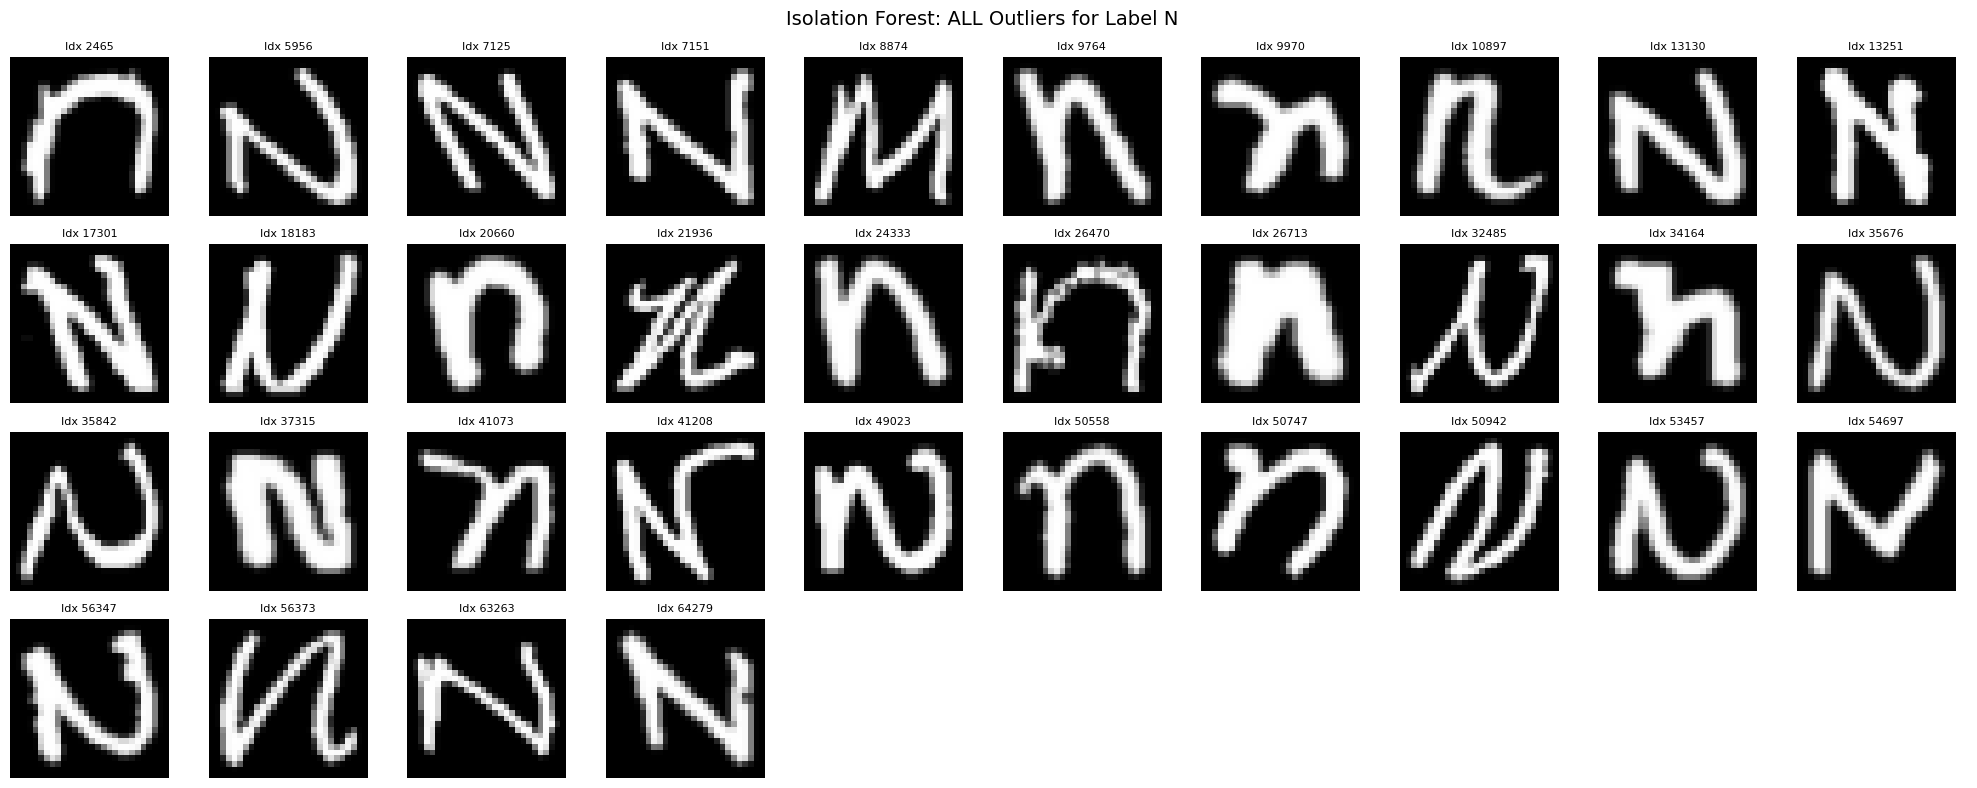

Label O: Found 35 outliers out of 3408 samples.


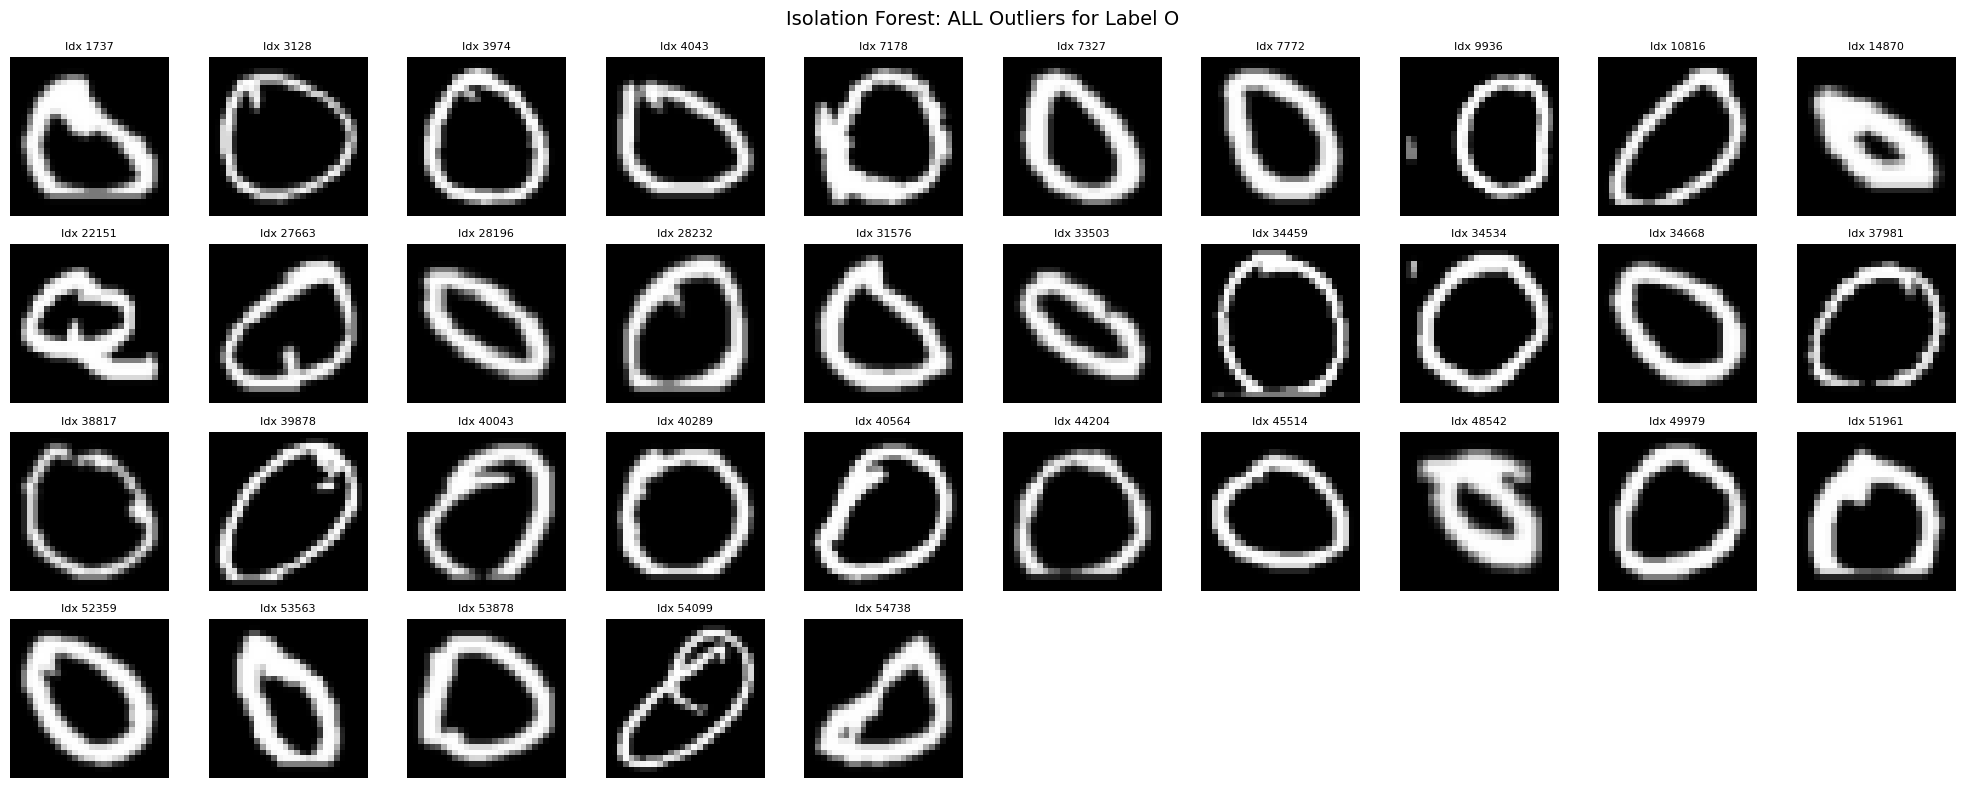

Label P: Found 35 outliers out of 3430 samples.


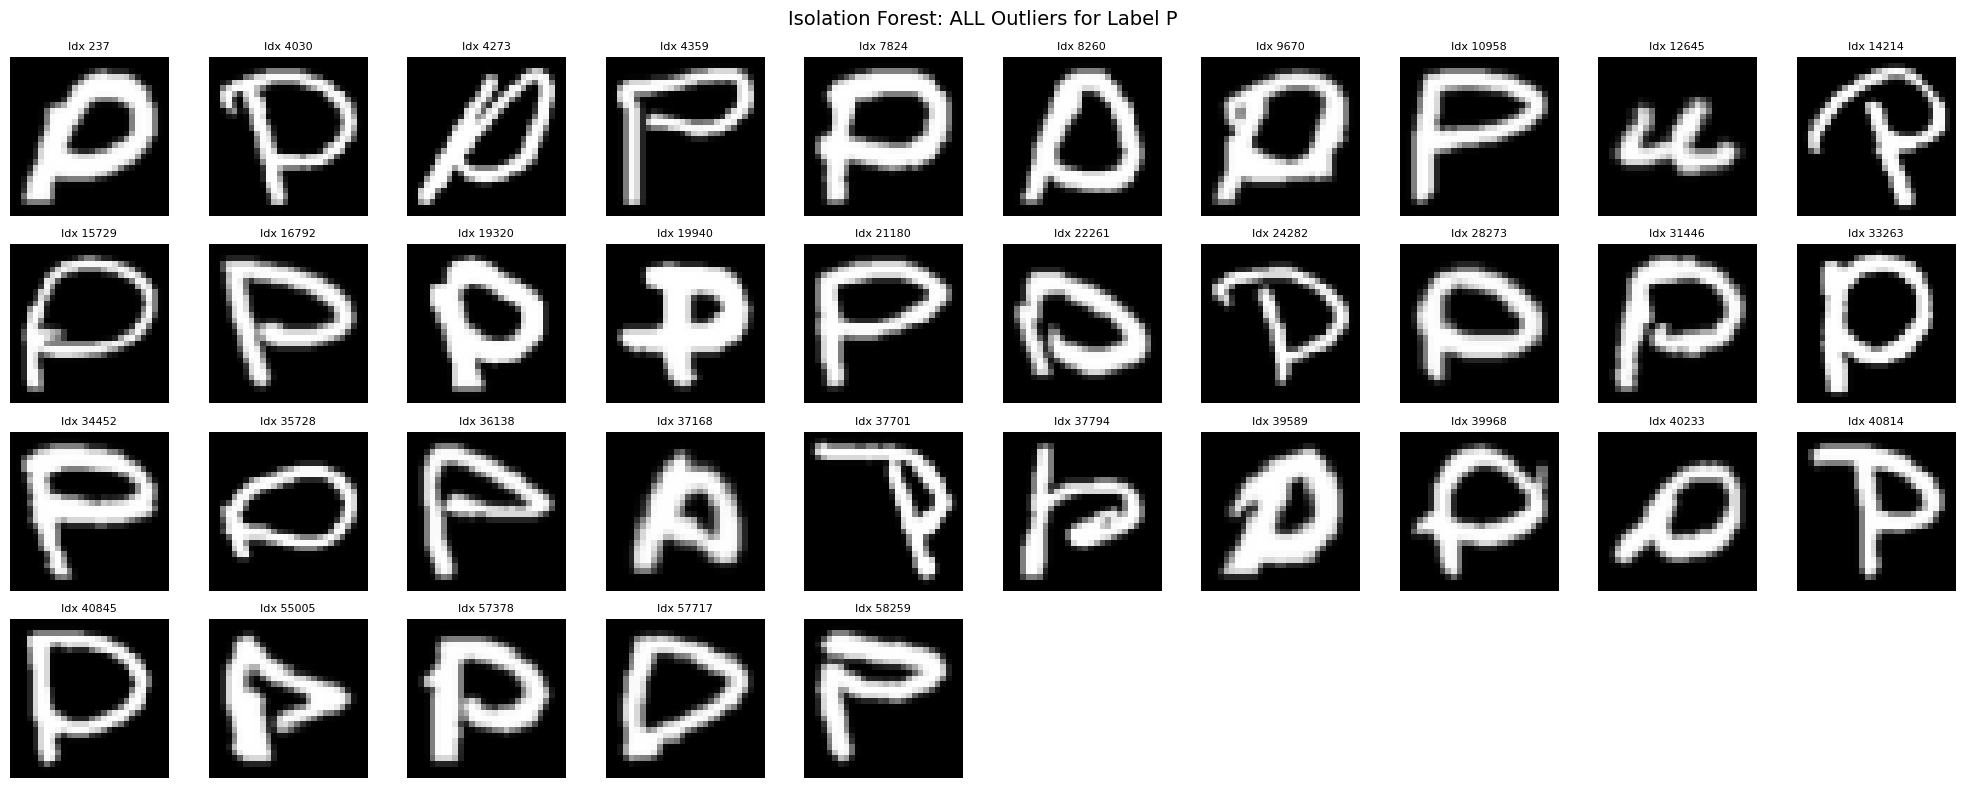

Label Q: Found 35 outliers out of 3435 samples.


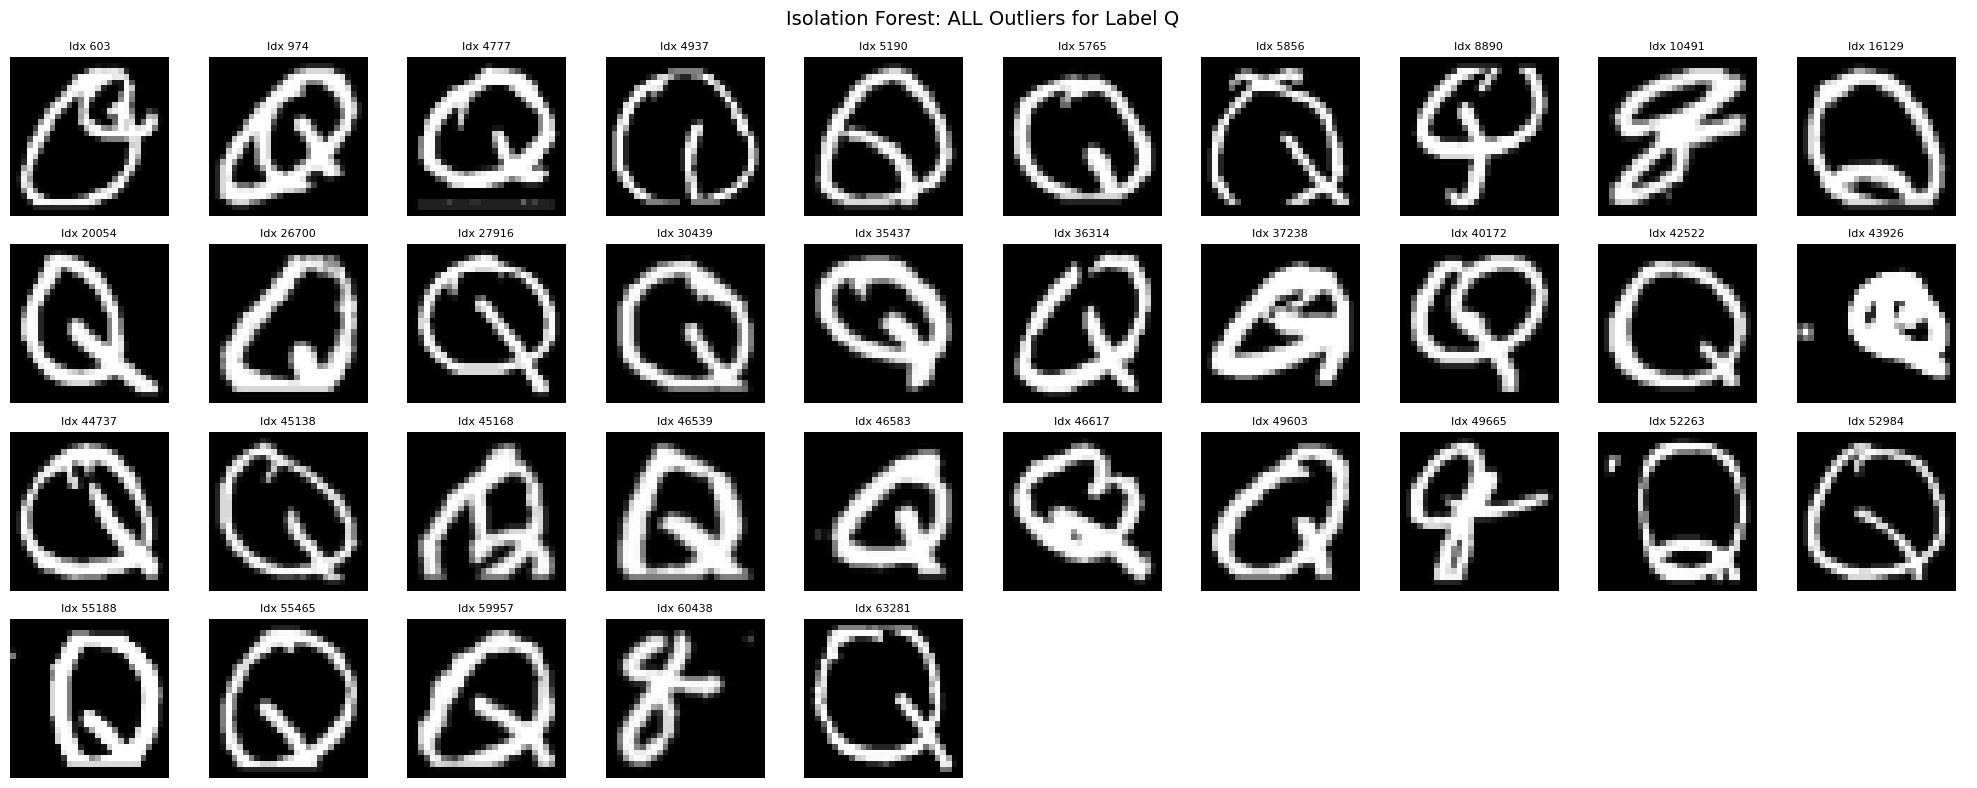

Label T: Found 35 outliers out of 3436 samples.


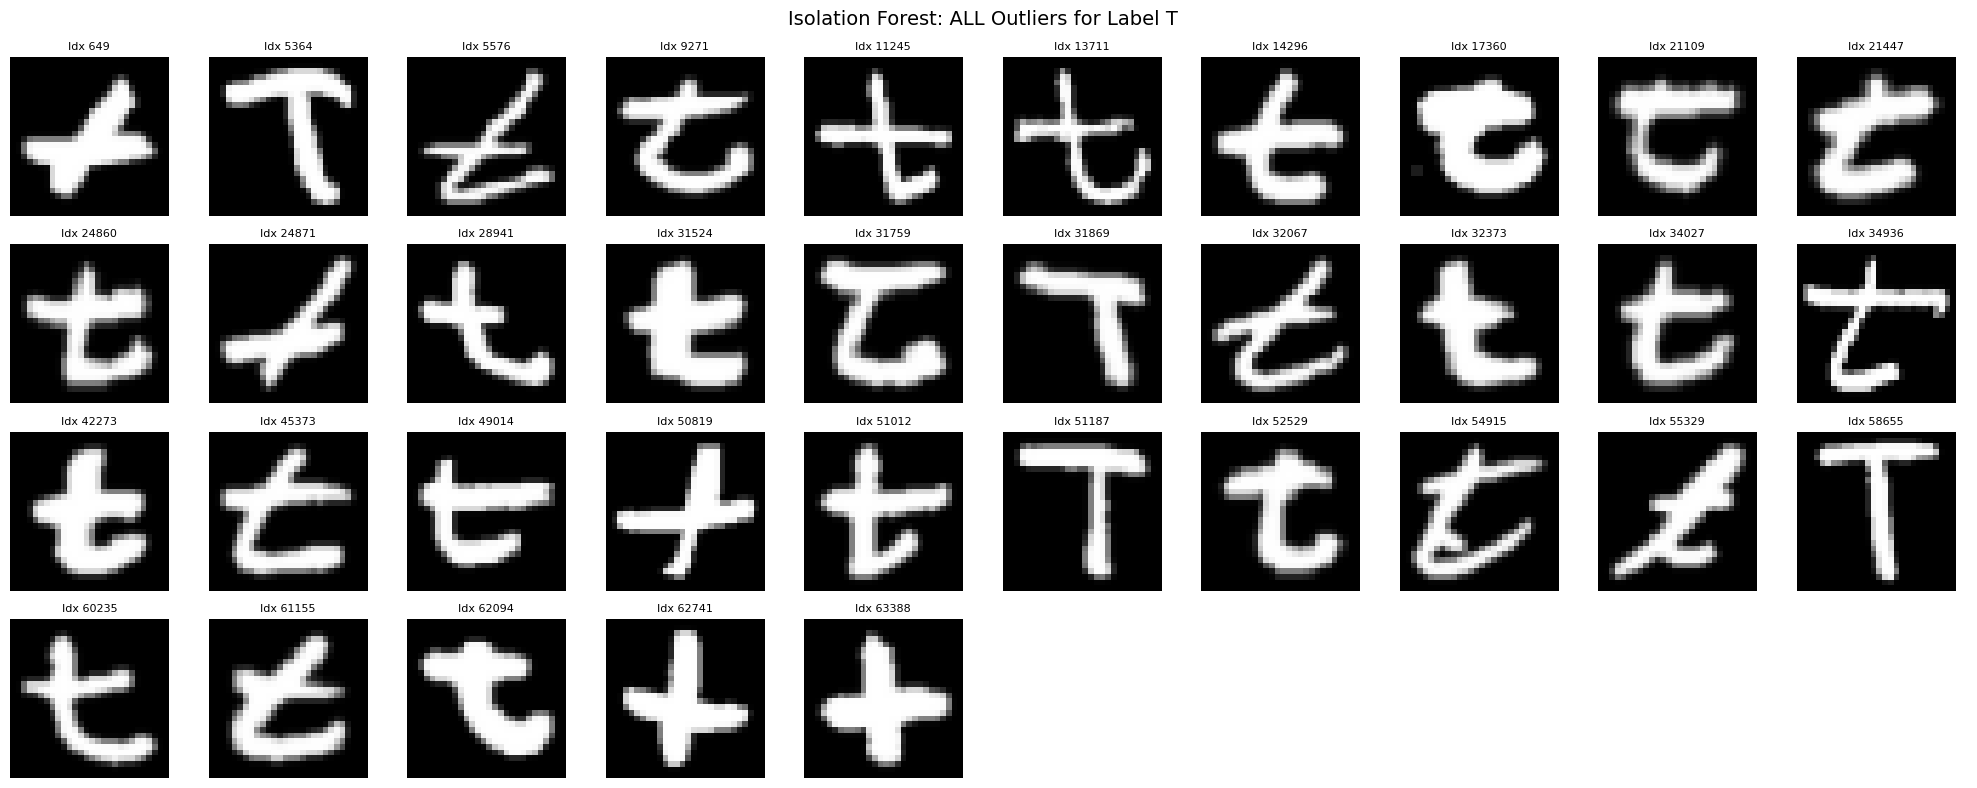

Label X: Found 35 outliers out of 3437 samples.


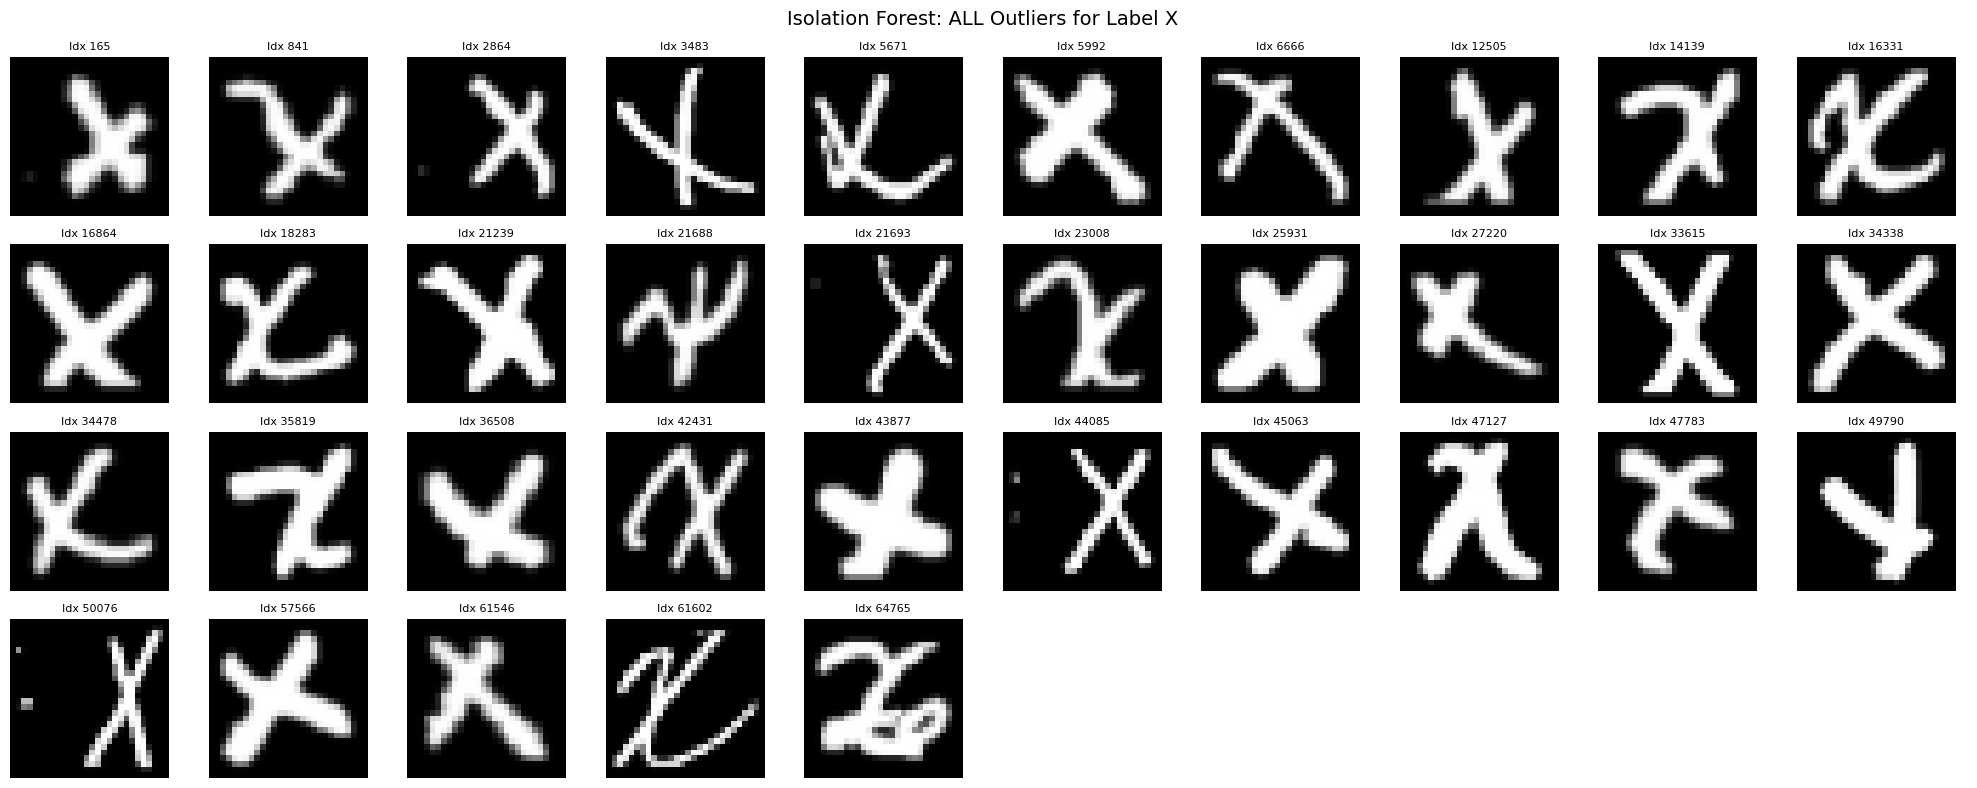

Label Z: Found 35 outliers out of 3427 samples.


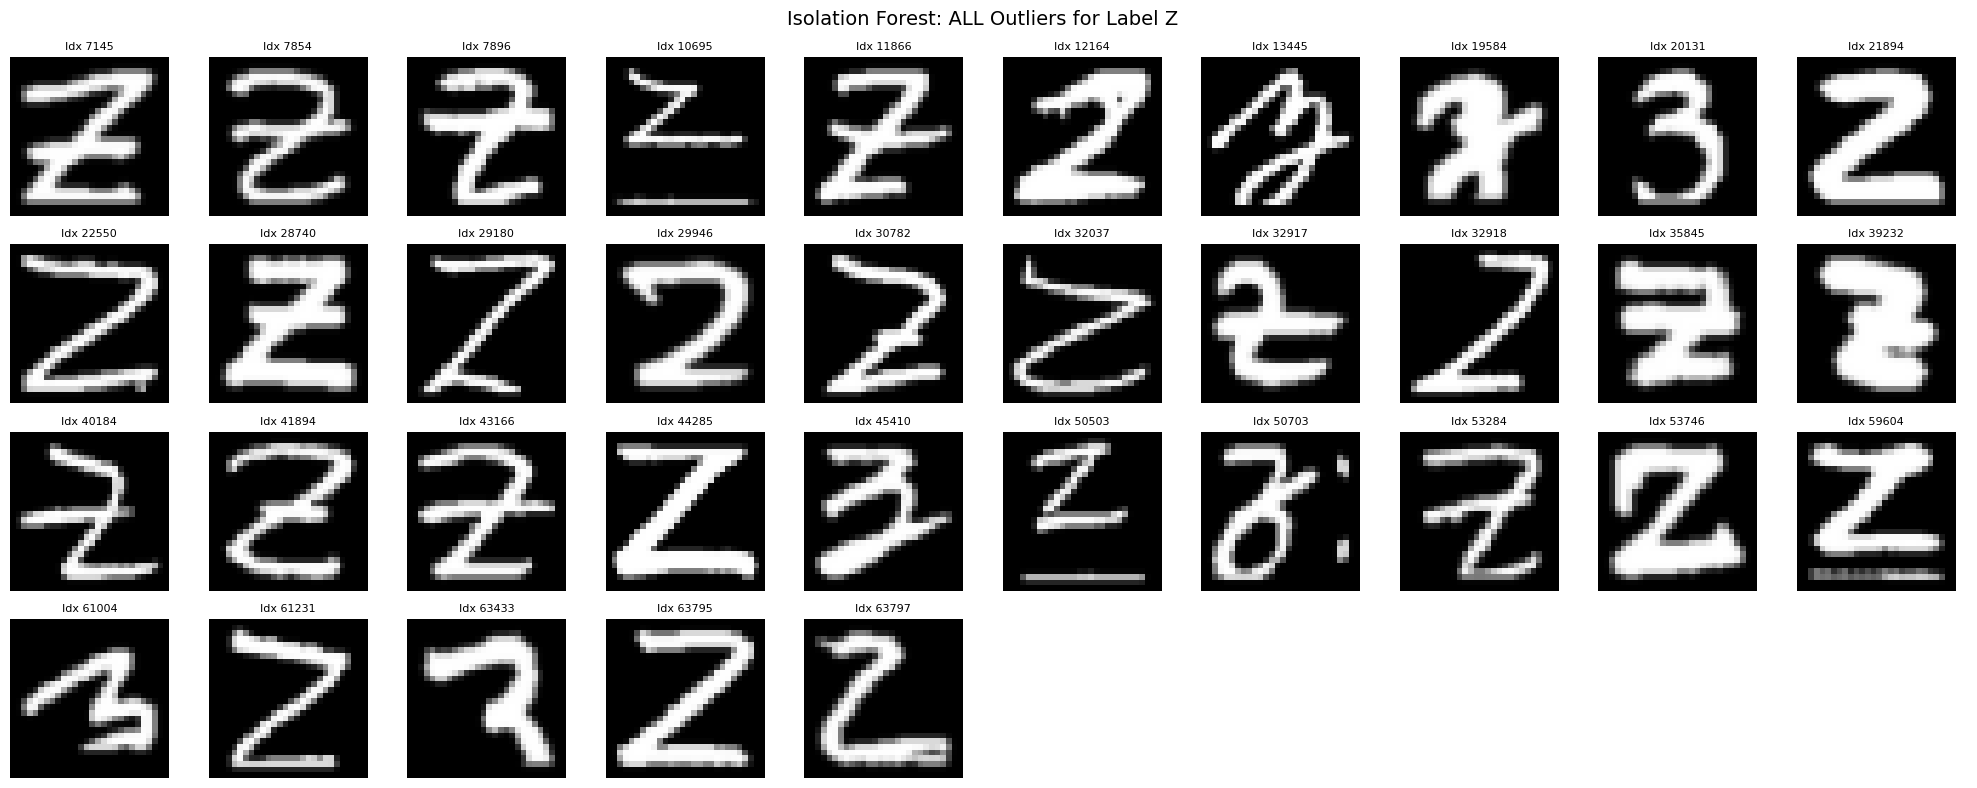


Total Isolation Forest outliers: 554


In [12]:
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import numpy as np

# Function to find ALL outliers and visualize them
def find_and_visualize_all_outliers_iso(data, pixel_columns, contamination=0.01, max_per_row=10):
    outlier_indices_by_label = {}
    labels = sorted(data['label'].unique())

    print(f"=== ISOLATION FOREST: FINDING AND VISUALIZING ALL OUTLIERS ===")

    for label in labels:
        subset = data[data['label'] == label]
        X = subset[pixel_columns].values.astype(np.float32)

        # Use IsolationForest to detect outliers
        iso = IsolationForest(contamination=contamination, random_state=42)
        preds = iso.fit_predict(X)
        outlier_mask = preds == -1
        outlier_indices = subset.index[outlier_mask].tolist()
        outlier_indices_by_label[label] = outlier_indices

        print(f"Label {label}: Found {len(outlier_indices)} outliers out of {len(subset)} samples.")

        # Visualize ALL outliers for this label
        if len(outlier_indices) > 0:
            outlier_data = subset.loc[outlier_indices]

            # Calculate grid dimensions
            n_outliers = len(outlier_data)
            n_rows = (n_outliers + max_per_row - 1) // max_per_row
            n_cols = min(max_per_row, n_outliers)

            fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*2, n_rows*2))

            # Handle single row/column cases
            if n_rows == 1 and n_cols == 1:
                axes = [axes]
            elif n_rows == 1:
                axes = axes.reshape(1, -1)
            elif n_cols == 1:
                axes = axes.reshape(-1, 1)

            # Plot each outlier
            for i, (_, row) in enumerate(outlier_data.iterrows()):
                row_idx = i // max_per_row
                col_idx = i % max_per_row

                img = row[pixel_columns].values.astype(np.float32).reshape(28, 28)

                if n_rows == 1:
                    ax = axes[col_idx]
                else:
                    ax = axes[row_idx, col_idx]

                ax.imshow(img, cmap='gray')
                ax.set_title(f"Idx {row.name}", fontsize=8)
                ax.axis('off')

            # Hide unused subplots
            total_subplots = n_rows * n_cols
            for i in range(n_outliers, total_subplots):
                row_idx = i // max_per_row
                col_idx = i % max_per_row
                if n_rows == 1:
                    axes[col_idx].axis('off')
                else:
                    axes[row_idx, col_idx].axis('off')

            plt.suptitle(f"Isolation Forest: ALL Outliers for Label {label}", fontsize=14)
            plt.tight_layout()
            plt.show()
        else:
            print(f"No outliers to visualize for label {label}")

    return outlier_indices_by_label

# Run outlier detection and visualize ALL outliers
iso_outlier_indices = find_and_visualize_all_outliers_iso(rotated_data, pixel_columns, contamination=0.01)

# Print summary
total_iso_outliers = sum(len(indices) for indices in iso_outlier_indices.values())
print(f"\nTotal Isolation Forest outliers: {total_iso_outliers}")

### Seperating Upper and Lower-case Letters
---

Class A:
subcluster
1    2303
0    1093
Name: count, dtype: int64


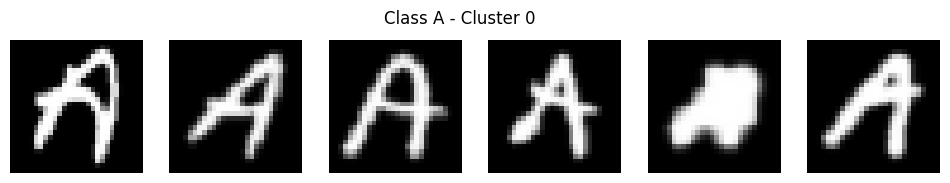

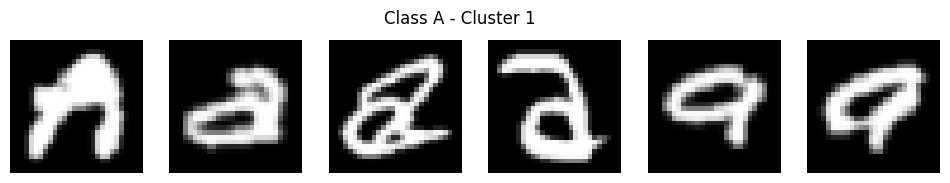

Class B:
subcluster
1    1958
0    1438
Name: count, dtype: int64


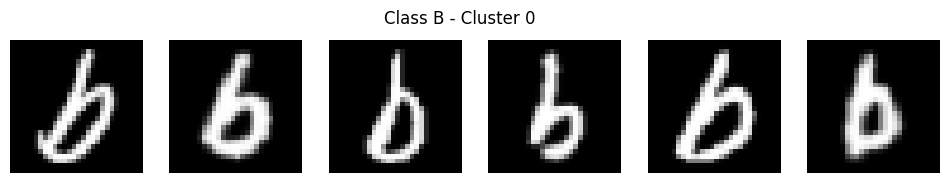

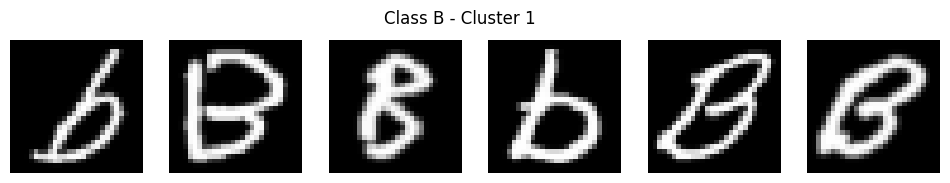

Class D:
subcluster
0    2269
1    1129
Name: count, dtype: int64


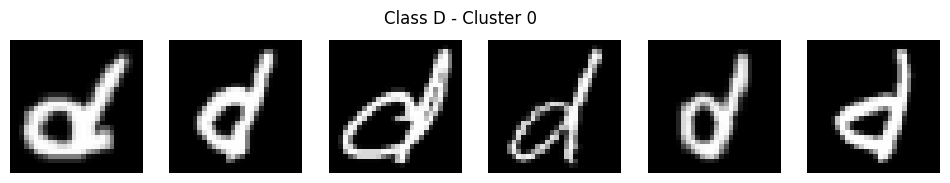

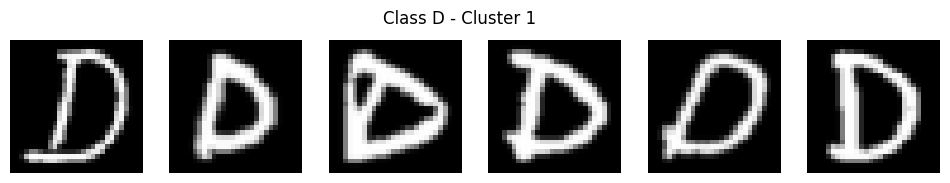

Class E:
subcluster
1    2267
0    1170
Name: count, dtype: int64


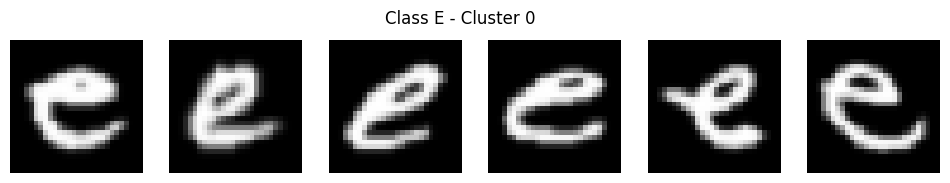

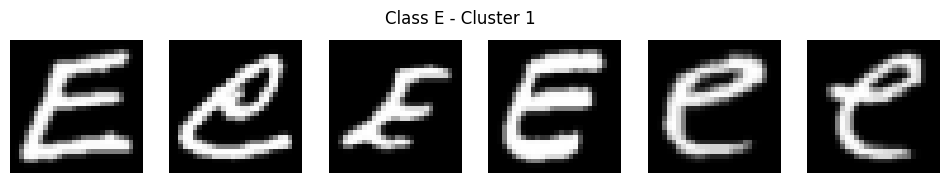

Class F:
subcluster
0    2035
1    1359
Name: count, dtype: int64


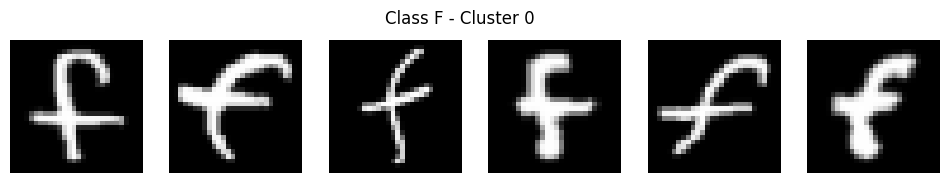

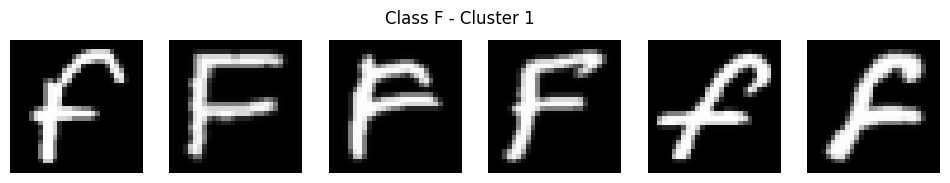

Class G:
subcluster
0    2107
1    1278
Name: count, dtype: int64


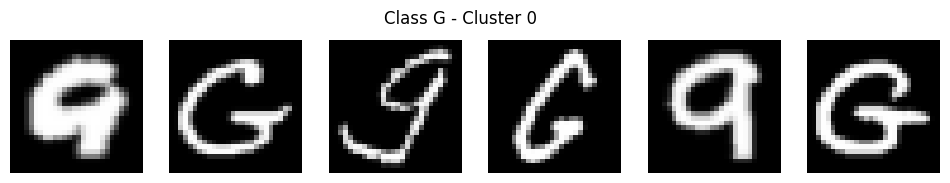

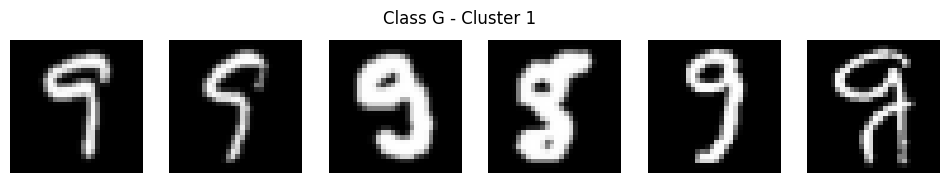

Class I:
subcluster
0    2298
1    1130
Name: count, dtype: int64


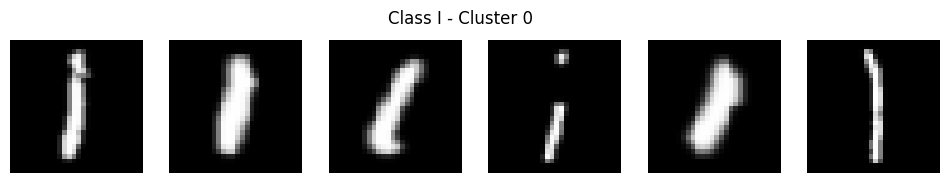

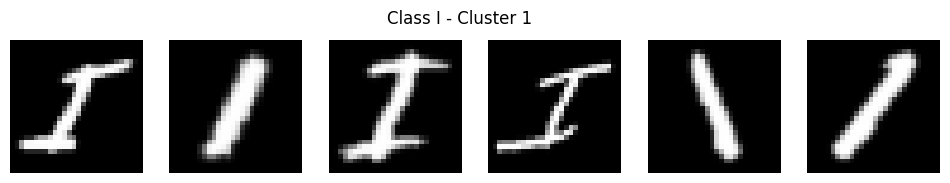

Class J:
subcluster
1    1794
0    1608
Name: count, dtype: int64


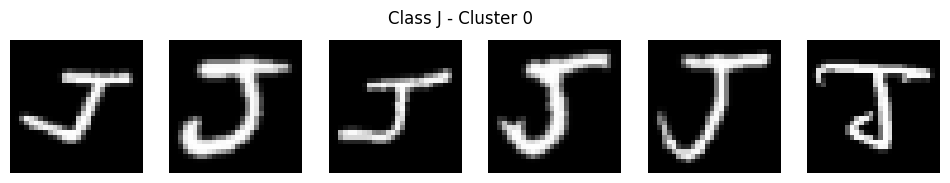

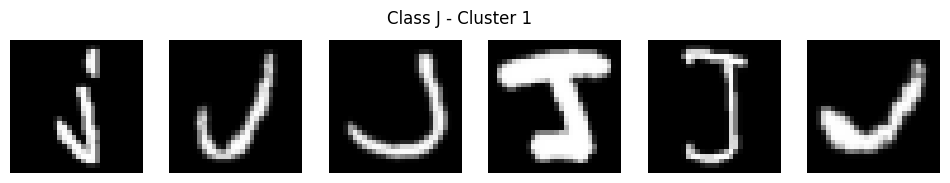

Class L:
subcluster
1    1979
0    1436
Name: count, dtype: int64


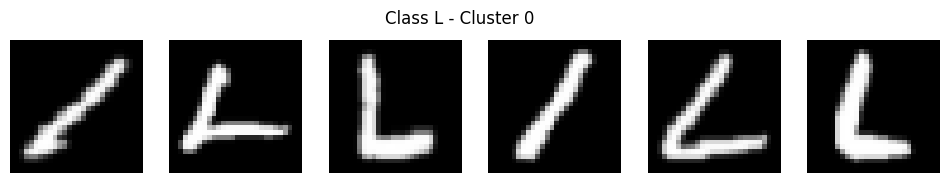

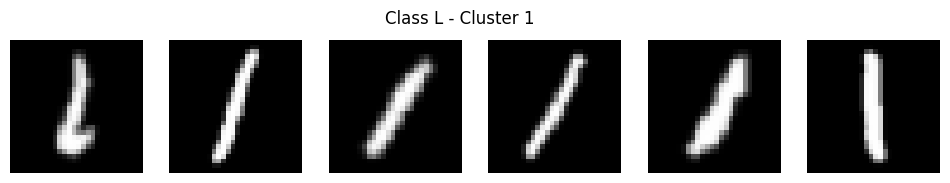

Class N:
subcluster
0    2001
1    1364
Name: count, dtype: int64


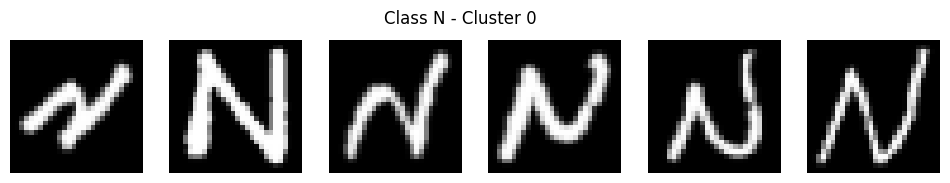

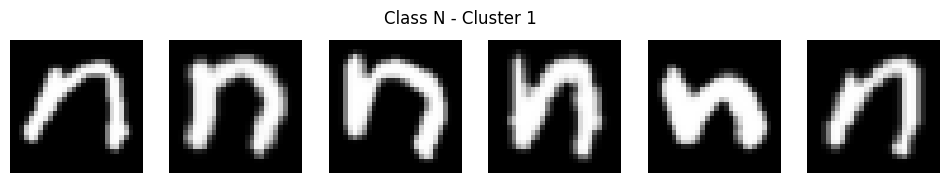

Class O:
subcluster
0    1740
1    1668
Name: count, dtype: int64


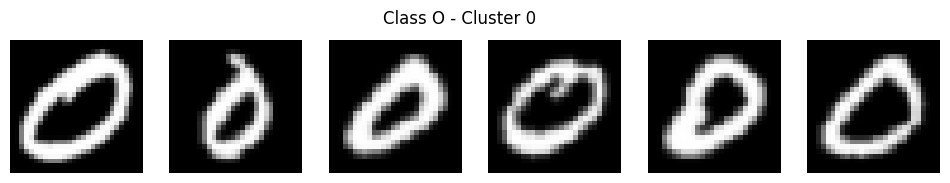

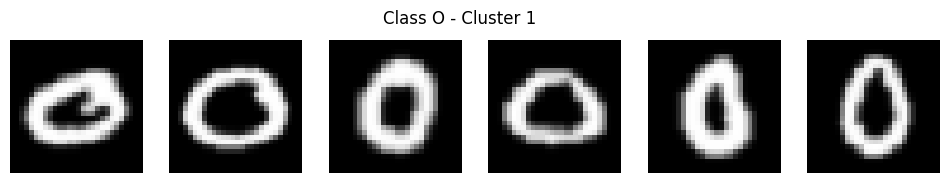

Class P:
subcluster
0    1720
1    1710
Name: count, dtype: int64


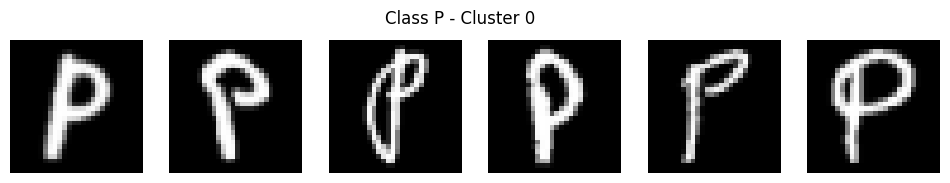

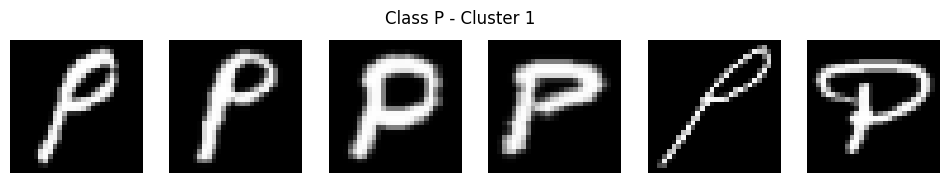

Class Q:
subcluster
1    2161
0    1274
Name: count, dtype: int64


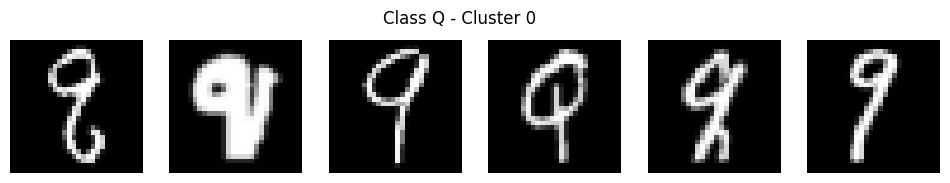

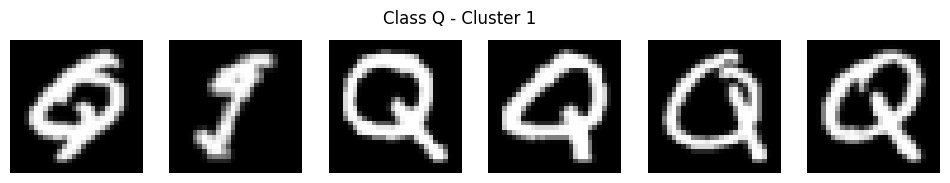

Class T:
subcluster
1    1940
0    1496
Name: count, dtype: int64


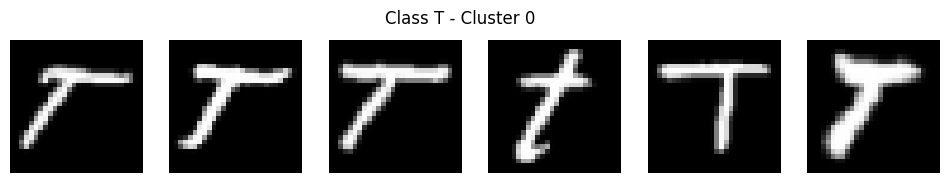

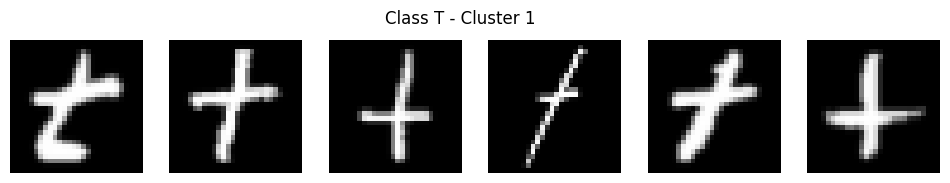

Class X:
subcluster
0    2049
1    1388
Name: count, dtype: int64


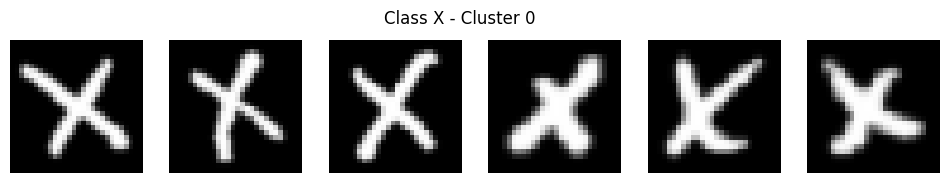

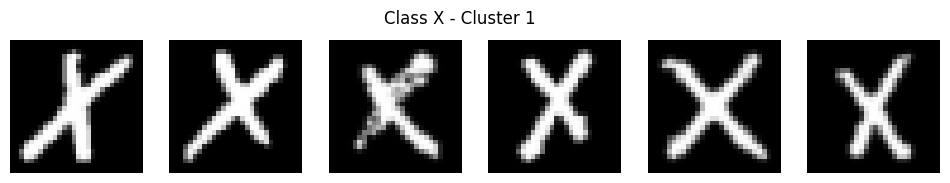

Class Z:
subcluster
1    2210
0    1217
Name: count, dtype: int64


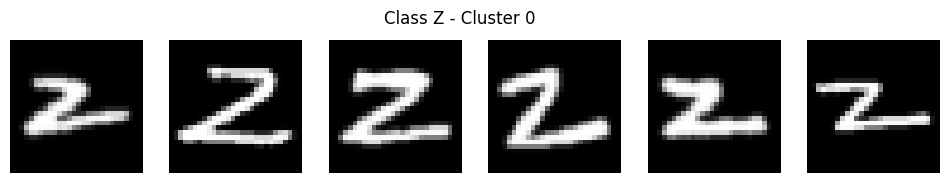

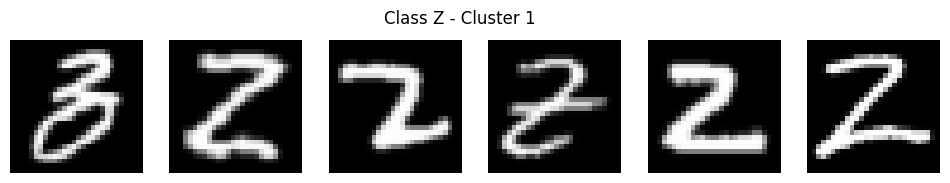

In [9]:
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Columns containing pixel values
pixel_columns = [col for col in rotated_data.columns if col.startswith('pixel_')]

# Unique class labels (e.g., 1 for A, 2 for B, ...)
class_labels = rotated_data['label'].unique()
class_labels.sort()

# Store clustered data
clustered_results = []

for class_id in class_labels:
    # Subset to current class
    class_data = rotated_data[rotated_data['label'] == class_id].copy()

    # Get flattened pixel values
    X_flat = class_data[pixel_columns].values

    # Dimensionality reduction using PCA
    pca = PCA(n_components=50, random_state=42)
    X_pca = pca.fit_transform(X_flat)

    # Gaussian Mixture Model (2 clusters)
    gmm = GaussianMixture(n_components=2, random_state=42)
    clusters = gmm.fit_predict(X_pca)

    # Save subcluster label
    class_data['subcluster'] = clusters

    # Show cluster counts
    print(f"Class {class_id}:")
    print(class_data['subcluster'].value_counts())

    # Visualize a few samples from each subcluster
    def show_cluster_samples(data, cluster_label, class_id, n_samples=6):
        samples = data[data['subcluster'] == cluster_label].sample(n=n_samples, random_state=42)
        fig, axes = plt.subplots(1, n_samples, figsize=(12, 2))
        for i, (_, row) in enumerate(samples.iterrows()):
            img = row[pixel_columns].values.astype(np.float32).reshape(28, 28)
            axes[i].imshow(img, cmap='gray')
            axes[i].axis('off')
        plt.suptitle(f"Class {class_id} - Cluster {cluster_label}")
        plt.show()

    show_cluster_samples(class_data, 0, class_id)
    show_cluster_samples(class_data, 1, class_id)

    # Append this class's data with subclusters
    clustered_results.append(class_data)

# Combine all class-clustered data into one dataframe
final_clustered_data = pd.concat(clustered_results, ignore_index=True)


### Data Preprocessing for GAN Training
---
Let's prepare the data for GAN training by normalizing and reshaping the images.

In [10]:
# Data preprocessing for GAN training
def preprocess_data(data):
    """Preprocess the EMNIST dataset for GAN training"""
    # Separate labels and pixel data
    labels = data['label'].values
    pixels = data.iloc[:, 1:].values

    # Reshape to 28x28 images and normalize to [-1, 1]
    images = pixels.reshape(-1, 28, 28)
    images = (images.astype(np.float32) - 127.5) / 127.5  # Normalize to [-1, 1]

    # Add channel dimension for compatibility with CNN layers
    images = np.expand_dims(images, axis=-1)

    print(f"Images shape: {images.shape}")
    print(f"Images range: [{images.min():.3f}, {images.max():.3f}]")
    print(f"Unique labels: {sorted(np.unique(labels))}")

    return images, labels

# Preprocess the data
X_train, y_train = preprocess_data(rotated_data)

# Create a mapping from original labels to sequential indices
unique_labels = sorted(np.unique(y_train))
label_mapping = {label: idx for idx, label in enumerate(unique_labels)}
y_train_encoded = np.array([label_mapping[label] for label in y_train])

print(f"\nLabel mapping: {label_mapping}")
print(f"Number of classes: {len(unique_labels)}")

# Check class distribution
class_counts = np.bincount(y_train_encoded)
print(f"\nClass distribution (encoded):")
for i, count in enumerate(class_counts):
    print(f"Class {i} (original: {unique_labels[i]}): {count} samples")

ValueError: cannot reshape array of size 42906954 into shape (28,28)

## GAN Implementation
---

### 3. GAN Training Implementation
---
Let's implement the training loop for our conditional GAN.

In [ ]:
class ConditionalGAN:
    def __init__(self, img_shape=(28, 28, 1), latent_dim=100, num_classes=26, embedding_dim=50):
        self.img_shape = img_shape
        self.latent_dim = latent_dim
        self.num_classes = num_classes
        self.embedding_dim = embedding_dim
        self.cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

        # Build models
        self.generator = self.build_generator()
        self.discriminator = self.build_discriminator()

        # Optimizers
        self.gen_optimizer = optimizers.Adam(1e-4)
        self.disc_optimizer = optimizers.Adam(1e-4)

        # Track losses
        self.d_losses = []
        self.g_losses = []

    def build_generator(self):
        noise_input = layers.Input(shape=(self.latent_dim,))
        label_input = layers.Input(shape=(1,), dtype='int32')

        label_embedding = layers.Embedding(self.num_classes, self.embedding_dim)(label_input)
        label_embedding = layers.Flatten()(label_embedding)
        x = layers.Concatenate()([noise_input, label_embedding])

        x = layers.Dense(7*7*256, use_bias=False)(x)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU()(x)

        x = layers.Reshape((7, 7, 256))(x)

        x = layers.Conv2DTranspose(128, 5, strides=1, padding='same', use_bias=False)(x)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU()(x)

        x = layers.Conv2DTranspose(64, 5, strides=2, padding='same', use_bias=False)(x)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU()(x)

        x = layers.Conv2DTranspose(1, 5, strides=2, padding='same', use_bias=False, activation='tanh')(x)

        return tf.keras.Model([noise_input, label_input], x)

    def build_discriminator(self):
        image_input = layers.Input(shape=self.img_shape)
        label_input = layers.Input(shape=(1,), dtype='int32')

        label_embedding = layers.Embedding(self.num_classes, np.prod(self.img_shape))(label_input)
        label_embedding = layers.Reshape(self.img_shape)(label_embedding)

        x = layers.Concatenate()([image_input, label_embedding])
        x = layers.Conv2D(64, 5, strides=2, padding='same')(x)
        x = layers.LeakyReLU()(x)
        x = layers.Dropout(0.3)(x)

        x = layers.Conv2D(128, 5, strides=2, padding='same')(x)
        x = layers.LeakyReLU()(x)
        x = layers.Dropout(0.3)(x)

        x = layers.Flatten()(x)
        x = layers.Dense(1)(x)

        return tf.keras.Model([image_input, label_input], x)

    def discriminator_loss(self, real_output, fake_output):
        real_loss = self.cross_entropy(tf.ones_like(real_output), real_output)
        fake_loss = self.cross_entropy(tf.zeros_like(fake_output), fake_output)
        return real_loss + fake_loss

    def generator_loss(self, fake_output):
        return self.cross_entropy(tf.ones_like(fake_output), fake_output)

    @tf.function
    def train_step(self, images, labels):
        noise = tf.random.normal([images.shape[0], self.latent_dim])
        gen_labels = tf.random.uniform([images.shape[0], 1], minval=0, maxval=self.num_classes, dtype=tf.int32)

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = self.generator([noise, gen_labels], training=True)

            real_output = self.discriminator([images, tf.expand_dims(labels, axis=1)], training=True)
            fake_output = self.discriminator([generated_images, gen_labels], training=True)

            g_loss = self.generator_loss(fake_output)
            d_loss = self.discriminator_loss(real_output, fake_output)

        gradients_gen = gen_tape.gradient(g_loss, self.generator.trainable_variables)
        gradients_disc = disc_tape.gradient(d_loss, self.discriminator.trainable_variables)

        self.gen_optimizer.apply_gradients(zip(gradients_gen, self.generator.trainable_variables))
        self.disc_optimizer.apply_gradients(zip(gradients_disc, self.discriminator.trainable_variables))

        return d_loss, g_loss

    def train(self, dataset, epochs=30, sample_interval=5):
        fixed_noise = tf.random.normal([16, self.latent_dim])
        fixed_labels = tf.constant([[i % self.num_classes] for i in range(16)], dtype=tf.int32)

        for epoch in range(epochs):
            for batch_images, batch_labels in dataset:
                d_loss, g_loss = self.train_step(batch_images, batch_labels)

            self.d_losses.append(d_loss.numpy())
            self.g_losses.append(g_loss.numpy())

            if (epoch + 1) % sample_interval == 0 or epoch == 0:
                print(f"Epoch {epoch+1} [D loss: {d_loss:.4f}] [G loss: {g_loss:.4f}]")
                self.sample_images(epoch, fixed_noise, fixed_labels)

    def sample_images(self, epoch, noise, labels):
        gen_imgs = self.generator([noise, labels], training=False)
        gen_imgs = (gen_imgs + 1) / 2.0  # [-1, 1] -> [0, 1]

        fig, axs = plt.subplots(4, 4, figsize=(8, 8))
        cnt = 0
        for i in range(4):
            for j in range(4):
                axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
                axs[i, j].set_title(f"Class {labels[cnt].numpy()[0]}")
                axs[i, j].axis('off')
                cnt += 1
        plt.suptitle(f"Generated Images at Epoch {epoch+1}")
        plt.tight_layout()
        plt.show()

    def generate_specific_class(self, class_label, num_samples=16):
        noise = tf.random.normal([num_samples, self.latent_dim])
        labels = tf.constant([[class_label]] * num_samples, dtype=tf.int32)
        gen_imgs = self.generator([noise, labels], training=False)
        gen_imgs = (gen_imgs + 1) / 2.0

        rows = int(np.sqrt(num_samples))
        cols = int(np.ceil(num_samples / rows))

        fig, axs = plt.subplots(rows, cols, figsize=(12, 12))
        axs = axs.flatten()

        for i in range(num_samples):
            axs[i].imshow(gen_imgs[i, :, :, 0], cmap='gray')
            axs[i].set_title(f"Class {class_label}")
            axs[i].axis('off')
        for i in range(num_samples, len(axs)):
            axs[i].axis('off')

        plt.suptitle(f"Generated Samples for Class {class_label}")
        plt.tight_layout()
        plt.show()

        return gen_imgs

### 4. GAN Training and Generation
---
Let's train our conditional GAN and generate the required 160 images (10 per class for 16 classes).

In [ ]:
BATCH_SIZE = 256
BUFFER_SIZE = len(X_train)
NUM_CLASSES = len(np.unique(unique_labels))

# Create TensorFlow dataset
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train_encoded))
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Initialize and train
cgan = ConditionalGAN(img_shape=(28, 28, 1), latent_dim=100, num_classes=NUM_CLASSES)


In [ ]:
# training for demonstration (reduce epochs for faster execution)

cgan.train(train_dataset, epochs=30, sample_interval=5)

### 5. Generate Required 160 Images (10 per class)
---
Now let's generate 10 images for each of the 16 classes as required by the task.

In [ ]:
# Generate 160 images (10 per class for 16 classes)
def generate_final_images(cgan, num_classes=16, images_per_class=10):
    """Generate final set of images for submission"""
    all_generated_images = []
    all_labels = []

    # Create directory for saving images
    os.makedirs('generated_images', exist_ok=True)

    for class_idx in range(num_classes):
        print(f"Generating images for class {class_idx}...")

        # Generate images for this class
        noise = np.random.normal(0, 1, (images_per_class, cgan.latent_dim))
        labels = np.full(images_per_class, class_idx)

        gen_imgs = cgan.generator.predict([noise, labels], verbose=0)
        gen_imgs = 0.5 * gen_imgs + 0.5  # Rescale to [0, 1]

        # Store images and labels
        all_generated_images.append(gen_imgs)
        all_labels.extend([class_idx] * images_per_class)

        # Save individual images
        for i, img in enumerate(gen_imgs):
            img_array = (img[:, :, 0] * 255).astype(np.uint8)
            img_pil = Image.fromarray(img_array, mode='L')
            img_pil.save(f'generated_images/class_{class_idx}_image_{i+1}.png')

    all_generated_images = np.vstack(all_generated_images)
    return all_generated_images, np.array(all_labels)

# Generate the final 160 images
generated_images, generated_labels = generate_final_images(cgan, num_classes=16, images_per_class=10)

print(f"Generated {len(generated_images)} images")
print(f"Images shape: {generated_images.shape}")
print(f"Unique classes: {np.unique(generated_labels)}")

# Display a sample of generated images in a grid
def display_generated_grid(images, labels, grid_size=(16, 10)):
    """Display generated images in a grid format"""
    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(20, 25))

    for i in range(grid_size[0]):  # classes
        for j in range(grid_size[1]):  # images per class
            idx = i * grid_size[1] + j
            if idx < len(images):
                axes[i, j].imshow(images[idx, :, :, 0], cmap='gray')
                axes[i, j].set_title(f'Class {labels[idx]}', fontsize=8)
            axes[i, j].axis('off')

    plt.suptitle('Generated Images - 160 Total (10 per class)', fontsize=16)
    plt.tight_layout()
    plt.show()

# Display all generated images
display_generated_grid(generated_images, generated_labels, grid_size=(16, 10))

### 6. Image Quality Evaluation
---
Let's evaluate the quality of our generated images using multiple approaches as suggested in the task.

In [ ]:
# 1. "Eye-power" evaluation - Manual assessment of 49 random images (7x7 grid)
def manual_evaluation_grid(images, labels, n_samples=49):
    """Display random sample for manual evaluation"""
    # Select random indices
    random_indices = np.random.choice(len(images), size=min(n_samples, len(images)), replace=False)

    grid_size = int(np.sqrt(n_samples))
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(15, 15))
    axes = axes.flatten()

    clear_count = 0
    marginal_count = 0
    nonsense_count = 0

    for i in range(n_samples):
        if i < len(random_indices):
            idx = random_indices[i]
            axes[i].imshow(images[idx, :, :, 0], cmap='gray')
            axes[i].set_title(f'Class {labels[idx]}', fontsize=10)
            axes[i].axis('off')

            # For demonstration, let's simulate manual evaluation
            # In practice, this would be done by human evaluator
            # Here we'll use a simple heuristic based on variance
            img_var = np.var(images[idx])
            if img_var > 0.01:  # High variance suggests clear structure
                clear_count += 1
            elif img_var > 0.005:  # Medium variance
                marginal_count += 1
            else:  # Low variance suggests noise
                nonsense_count += 1
        else:
            axes[i].axis('off')

    plt.suptitle('Manual Evaluation Sample (7x7 = 49 images)', fontsize=16)
    plt.tight_layout()
    plt.show()

    print(f"\\nSimulated Manual Evaluation Results:")
    print(f"Clear images: {clear_count}/{n_samples} ({clear_count/n_samples*100:.1f}%)")
    print(f"Marginal images: {marginal_count}/{n_samples} ({marginal_count/n_samples*100:.1f}%)")
    print(f"Nonsense images: {nonsense_count}/{n_samples} ({nonsense_count/n_samples*100:.1f}%)")

    return clear_count, marginal_count, nonsense_count

# Perform manual evaluation
clear, marginal, nonsense = manual_evaluation_grid(generated_images, generated_labels, n_samples=49)

In [ ]:
# 2. Additional Evaluation Metrics
def evaluate_image_quality(images):
    """Evaluate generated images using various metrics"""

    # Calculate basic statistics
    mean_pixel_intensity = np.mean(images)
    std_pixel_intensity = np.std(images)

    # Calculate per-image statistics
    image_variances = [np.var(img) for img in images]
    image_means = [np.mean(img) for img in images]

    # Diversity metrics
    pairwise_distances = []
    for i in range(min(50, len(images))):  # Sample to avoid computation explosion
        for j in range(i+1, min(50, len(images))):
            dist = np.mean((images[i] - images[j])**2)
            pairwise_distances.append(dist)

    diversity_score = np.mean(pairwise_distances)

    print("=== Image Quality Metrics ===")
    print(f"Mean pixel intensity: {mean_pixel_intensity:.4f}")
    print(f"Std pixel intensity: {std_pixel_intensity:.4f}")
    print(f"Average image variance: {np.mean(image_variances):.6f}")
    print(f"Diversity score (MSE): {diversity_score:.6f}")

    # Plot distributions
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    # Pixel intensity distribution
    axes[0,0].hist(images.flatten(), bins=50, alpha=0.7)
    axes[0,0].set_title('Pixel Intensity Distribution')
    axes[0,0].set_xlabel('Pixel Value')
    axes[0,0].set_ylabel('Frequency')

    # Image variance distribution
    axes[0,1].hist(image_variances, bins=30, alpha=0.7, color='orange')
    axes[0,1].set_title('Image Variance Distribution')
    axes[0,1].set_xlabel('Variance')
    axes[0,1].set_ylabel('Frequency')

    # Mean intensity per image
    axes[1,0].hist(image_means, bins=30, alpha=0.7, color='green')
    axes[1,0].set_title('Mean Intensity per Image')
    axes[1,0].set_xlabel('Mean Intensity')
    axes[1,0].set_ylabel('Frequency')

    # Training loss curves
    axes[1,1].plot(cgan.d_losses, label='Discriminator Loss', alpha=0.7)
    axes[1,1].plot(cgan.g_losses, label='Generator Loss', alpha=0.7)
    axes[1,1].set_title('Training Loss Curves')
    axes[1,1].set_xlabel('Training Steps')
    axes[1,1].set_ylabel('Loss')
    axes[1,1].legend()

    plt.tight_layout()
    plt.show()

    return {
        'mean_intensity': mean_pixel_intensity,
        'std_intensity': std_pixel_intensity,
        'avg_variance': np.mean(image_variances),
        'diversity_score': diversity_score
    }

# Evaluate image quality
quality_metrics = evaluate_image_quality(generated_images)

### 7. Analysis and Discussion
---

### 8. Summary and Recommendations
---
